# 0.0 Imports

In [4]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
from category_encoders import TargetEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from boruta import BorutaPy
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
from sklearn.pipeline import make_pipeline
import pickle as pkl
import time
from selenium import webdriver
from bs4 import BeautifulSoup
pd.set_option('display.max_columns', None)
filterwarnings('ignore')

# 1.0 Collect Data

In [1010]:
# Import
pesquisas = pd.read_csv('pesquisas_eleitorais.csv')
resultados = pd.read_csv('resultados_eleicao.csv')

In [1011]:
pesquisas

,id_pesquisa,ano,sigla_uf,nome_municipio,cargo,data,data_referencia,instituto,contratante,orgao_registro,numero_registro,quantidade_entrevistas,margem_mais,margem_menos,tipo,turno,tipo_voto,id_cenario,descricao_cenario,id_candidato_poder360,nome_candidato,sigla_partido,condicao,percentual
0,8023,2006,NaN,NaN,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,1508,Rui Costa Pimenta,PCO,0,0.0
1,8023,2006,NaN,NaN,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,938,Luciano Bivar,PSL,0,0.0
2,8023,2006,NaN,NaN,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,327,Cristovam Buarque,PDT,0,2.0
3,8023,2006,NaN,NaN,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,645,Heloísa Helena,Psol,0,9.0
4,8023,2006,NaN,NaN,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,806,Eymael,PSDC,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149397,3504,2014,RS,NaN,governador,2014-10-25,24-25.out.2014,Datafolha,Folha de S/ Paulo/TV Globo,TSE,BR- 01210/2014,19318.0,2.0,2.0,estimulada,2,votos válidos,8621,Diversos candidatos (votos válidos),801,José Ivo Sartori,PMDB,0,60.0
149398,3504,2014,RS,NaN,governador,2014-10-25,24-25.out.2014,Datafolha,Folha de S/ Paulo/TV Globo,TSE,BR- 01210/2014,19318.0,2.0,2.0,estimulada,2,votos válidos,8621,Diversos candidatos (votos válidos),1606,Tarso Genro,PT,0,40.0
149399,3504,2014,RS,NaN,governador,2014-10-25,24-25.out.2014,Datafolha,Folha de S/ Paulo/TV Globo,TSE,BR- 01210/2014,19318.0,2.0,2.0,estimulada,2,votos totais,8622,Diversos candidatos,801,José Ivo Sartori,PMDB,0,54.0
149400,3504,2014,RS,NaN,governador,2014-10-25,24-25.out.2014,Datafolha,Folha de S/ Paulo/TV Globo,TSE,BR- 01210/2014,19318.0,2.0,2.0,estimulada,2,votos totais,8622,Diversos candidatos,214,branco / nulo / não sabe / não respondeu,NaN,1,10.0


# 2.0 Data Cleaning

## 2.1 Filtering Rows 

In [1012]:
# Em uma primeira versão deste trabalho utilizarei apenas pesquisas de presidente da república
pesquisas = pesquisas[pesquisas['cargo']=='presidente']

# Em uma primeira versão deste trabalho utilizarei apenas dados das eleições de 2006 em diante
pesquisas = pesquisas[pesquisas['ano']>=2006]

## 2.2 NaN Values

In [1013]:
pesquisas.isna().sum()

id_pesquisa                   0
ano                           0
sigla_uf                  14241
nome_municipio            33041
cargo                         0
data                          0
data_referencia               0
instituto                     0
contratante                7470
orgao_registro             8339
numero_registro            8366
quantidade_entrevistas       29
margem_mais                   0
margem_menos                  0
tipo                        225
turno                         0
tipo_voto                     0
id_cenario                    0
descricao_cenario             0
id_candidato_poder360         0
nome_candidato                0
sigla_partido              9434
condicao                      0
percentual                    0
dtype: int64

### 2.2.1 Tipo do Cenário

In [1014]:
pesquisas[pesquisas['tipo'].isna()]

,id_pesquisa,ano,sigla_uf,nome_municipio,cargo,data,data_referencia,instituto,contratante,orgao_registro,numero_registro,quantidade_entrevistas,margem_mais,margem_menos,tipo,turno,tipo_voto,id_cenario,descricao_cenario,id_candidato_poder360,nome_candidato,sigla_partido,condicao,percentual
29,9225,2019,NaN,NaN,presidente,2019-08-31,28-31.ago.2019,IBPAD,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1,votos totais,23137,avaliação do governo,5441,Ruim/Péssimo,NaN,1,35.0
30,9225,2019,NaN,NaN,presidente,2019-08-31,28-31.ago.2019,IBPAD,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1,votos totais,23137,avaliação do governo,5440,Ótimo/Bom,NaN,1,37.0
31,9225,2019,NaN,NaN,presidente,2019-08-31,28-31.ago.2019,IBPAD,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1,votos totais,23137,avaliação do governo,5437,Regular,NaN,1,26.0
32,9225,2019,NaN,NaN,presidente,2019-08-31,28-31.ago.2019,IBPAD,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1,votos totais,23137,avaliação do governo,1210,não sabe / não respondeu,NaN,1,2.0
34759,9270,2019,NaN,NaN,presidente,2019-04-03,1-3.abr.2019,Vox Populi,PT,NaN,NaN,1985.0,2.2,2.2,NaN,1,votos totais,23240,avaliação do governo,5437,Regular,NaN,1,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109145,9307,2020,NaN,NaN,presidente,2020-06-24,22-24.jun.2020,DataPoder360,NaN,NaN,NaN,2500.0,2.0,2.0,NaN,1,votos totais,23293,avaliação do governo Bolsonaro,1210,não sabe / não respondeu,NaN,1,9.0
109146,9307,2020,NaN,NaN,presidente,2020-06-24,22-24.jun.2020,DataPoder360,NaN,NaN,NaN,2500.0,2.0,2.0,NaN,1,votos totais,23293,avaliação do governo Bolsonaro,5557,desaprova,NaN,0,49.0
109147,9305,2020,NaN,NaN,presidente,2020-06-10,8-10.jun.2020,DataPoder360,NaN,NaN,NaN,2500.0,2.0,2.0,NaN,1,votos totais,23294,avaliação do governo Bolsonaro,1210,não sabe / não respondeu,NaN,1,10.0
109148,9305,2020,NaN,NaN,presidente,2020-06-10,8-10.jun.2020,DataPoder360,NaN,NaN,NaN,2500.0,2.0,2.0,NaN,1,votos totais,23294,avaliação do governo Bolsonaro,5557,desaprova,NaN,0,50.0


Me parece que essas pesquisas não são eleitorais!

In [1015]:
pesquisas[pesquisas['tipo'].isna()]['descricao_cenario'].unique()

array(['avaliação do governo', 'avaliação de governo',
       'aprovação do governo', 'avaliação do  governo',
       'avaliação do governo (trabalho de Bolsonaro)',
       'avaliação do trabalho de Bolsonaro',
       'avaliação do governo Bolsonaro'], dtype=object)

De fato era isso. Vou dropar!

In [1016]:
pesquisas = pesquisas[~pesquisas['tipo'].isna()]

### 2.2.2 Município

In [1017]:
print('Número de linhas:',pesquisas.shape[0])
print('Número de linhas com município vazio:',pesquisas[(pesquisas['nome_municipio'].isna())].shape[0])

Número de linhas: 32823
Número de linhas com município vazio: 32816


In [1018]:
# Vou dropar, pois basicamente é tudo NaN
pesquisas = pesquisas.drop('nome_municipio',1)

### 2.2.3 UF

In [1019]:
# UF vazia
pesquisas[(pesquisas['sigla_uf'].isna())]

,id_pesquisa,ano,sigla_uf,cargo,data,data_referencia,instituto,contratante,orgao_registro,numero_registro,quantidade_entrevistas,margem_mais,margem_menos,tipo,turno,tipo_voto,id_cenario,descricao_cenario,id_candidato_poder360,nome_candidato,sigla_partido,condicao,percentual
0,8023,2006,NaN,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,1508,Rui Costa Pimenta,PCO,0,0.0
1,8023,2006,NaN,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,938,Luciano Bivar,PSL,0,0.0
2,8023,2006,NaN,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,327,Cristovam Buarque,PDT,0,2.0
3,8023,2006,NaN,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,645,Heloísa Helena,Psol,0,9.0
4,8023,2006,NaN,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,806,Eymael,PSDC,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149377,3487,2014,NaN,presidente,2014-10-25,25/OUT/2014,Datafolha,Folha de S/ Paulo/TV Globo,TSE,BR- 01210/2014,19318.0,2.0,2.0,estimulada,2,votos totais,8594,Diversos candidatos,176,Aécio Neves,PSDB,0,43.0
149378,3487,2014,NaN,presidente,2014-10-25,25/OUT/2014,Datafolha,Folha de S/ Paulo/TV Globo,TSE,BR- 01210/2014,19318.0,2.0,2.0,estimulada,2,votos totais,8594,Diversos candidatos,214,branco / nulo / não sabe / não respondeu,NaN,1,10.0
149379,3487,2014,NaN,presidente,2014-10-25,25/OUT/2014,Datafolha,Folha de S/ Paulo/TV Globo,TSE,BR- 01210/2014,19318.0,2.0,2.0,estimulada,2,votos totais,8594,Diversos candidatos,361,Dilma Rousseff,PT,0,47.0
149380,3488,2014,NaN,presidente,2014-10-25,25/Oct/2014,Datafolha,Folha de S/ Paulo/TV Globo,TSE,BR- 01210/2014,19318.0,2.0,2.0,estimulada,2,votos totais,8595,Diversos candidatos (votos válidos),176,Aécio Neves,PSDB,0,48.0


In [1020]:
# Por agora vou dropar, mas posso rever depois (dada a grande quantidade de NaN)
pesquisas = pesquisas.drop('sigla_uf',1)

### 2.2.4 Contratante

In [1021]:
pesquisas[pesquisas['contratante'].isna()]

,id_pesquisa,ano,cargo,data,data_referencia,instituto,contratante,orgao_registro,numero_registro,quantidade_entrevistas,margem_mais,margem_menos,tipo,turno,tipo_voto,id_cenario,descricao_cenario,id_candidato_poder360,nome_candidato,sigla_partido,condicao,percentual
0,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,1508,Rui Costa Pimenta,PCO,0,0.0
1,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,938,Luciano Bivar,PSL,0,0.0
2,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,327,Cristovam Buarque,PDT,0,2.0
3,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,645,Heloísa Helena,Psol,0,9.0
4,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,806,Eymael,PSDC,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148787,7633,2018,presidente,2017-09-04,1-4.set.2017,Instituto Falpe,NaN,NaN,NaN,1534.0,3.0,3.0,estimulada,1,votos totais,18909,cenário estimulado,855,João Doria,PSDB,0,1.5
148788,7633,2018,presidente,2017-09-04,1-4.set.2017,Instituto Falpe,NaN,NaN,NaN,1534.0,3.0,3.0,estimulada,1,votos totais,18909,cenário estimulado,973,Lula,PT,0,51.5
148789,7633,2018,presidente,2017-09-04,1-4.set.2017,Instituto Falpe,NaN,NaN,NaN,1534.0,3.0,3.0,estimulada,1,votos totais,18909,cenário estimulado,678,indeciso / não sabe / não respondeu,NaN,1,16.0
148790,7633,2018,presidente,2017-09-04,1-4.set.2017,Instituto Falpe,NaN,NaN,NaN,1534.0,3.0,3.0,estimulada,1,votos totais,18909,cenário estimulado,575,Alckmin,PSDB,0,2.0


In [1022]:
# Vou imputar um valor por enquanto
pesquisas['contratante'] = pesquisas['contratante'].fillna('Sem dados')

### 2.2.5 Órgão e Número de Registro

In [1023]:
# Ambos vazios
pesquisas[(pesquisas['orgao_registro'].isna())&(pesquisas['numero_registro'].isna())]

,id_pesquisa,ano,cargo,data,data_referencia,instituto,contratante,orgao_registro,numero_registro,quantidade_entrevistas,margem_mais,margem_menos,tipo,turno,tipo_voto,id_cenario,descricao_cenario,id_candidato_poder360,nome_candidato,sigla_partido,condicao,percentual
0,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,Sem dados,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,1508,Rui Costa Pimenta,PCO,0,0.0
1,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,Sem dados,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,938,Luciano Bivar,PSL,0,0.0
2,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,Sem dados,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,327,Cristovam Buarque,PDT,0,2.0
3,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,Sem dados,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,645,Heloísa Helena,Psol,0,9.0
4,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,Sem dados,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,806,Eymael,PSDC,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148787,7633,2018,presidente,2017-09-04,1-4.set.2017,Instituto Falpe,Sem dados,NaN,NaN,1534.0,3.0,3.0,estimulada,1,votos totais,18909,cenário estimulado,855,João Doria,PSDB,0,1.5
148788,7633,2018,presidente,2017-09-04,1-4.set.2017,Instituto Falpe,Sem dados,NaN,NaN,1534.0,3.0,3.0,estimulada,1,votos totais,18909,cenário estimulado,973,Lula,PT,0,51.5
148789,7633,2018,presidente,2017-09-04,1-4.set.2017,Instituto Falpe,Sem dados,NaN,NaN,1534.0,3.0,3.0,estimulada,1,votos totais,18909,cenário estimulado,678,indeciso / não sabe / não respondeu,NaN,1,16.0
148790,7633,2018,presidente,2017-09-04,1-4.set.2017,Instituto Falpe,Sem dados,NaN,NaN,1534.0,3.0,3.0,estimulada,1,votos totais,18909,cenário estimulado,575,Alckmin,PSDB,0,2.0


In [1024]:
# Com número, mas sem órgão
pesquisas[(pesquisas['orgao_registro'].isna())&(pesquisas['numero_registro'].notna())]

,id_pesquisa,ano,cargo,data,data_referencia,instituto,contratante,orgao_registro,numero_registro,quantidade_entrevistas,margem_mais,margem_menos,tipo,turno,tipo_voto,id_cenario,descricao_cenario,id_candidato_poder360,nome_candidato,sigla_partido,condicao,percentual


In [1025]:
# Sem número, mas com órgão
pesquisas[(pesquisas['orgao_registro'].notna())&(pesquisas['numero_registro'].isna())]

,id_pesquisa,ano,cargo,data,data_referencia,instituto,contratante,orgao_registro,numero_registro,quantidade_entrevistas,margem_mais,margem_menos,tipo,turno,tipo_voto,id_cenario,descricao_cenario,id_candidato_poder360,nome_candidato,sigla_partido,condicao,percentual
89668,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,706,Bolsonaro,sem partido,0,34.0
89669,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,4982,branco / nulo / nenhum,NaN,1,7.5
89670,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,855,João Doria,PSDB,0,5.2
89671,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,973,Lula,PT,0,29.3
89672,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,841,João Amoêdo,Novo,0,4.1
89673,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,3438,Luiz Henrique Mandetta,DEM,0,1.5
89674,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,289,Ciro,PDT,0,5.9
89675,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,1210,não sabe / não respondeu,NaN,1,3.4
89676,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,1563,Simone Tebet,MDB,0,0.3
89677,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,3152,José Luiz Datena,sem partido,0,9.0


In [1026]:
# Vou dropar o número de registro, pois ele decorre do órgão (não tem número sem órgão)
pesquisas.drop('numero_registro',1,inplace=True)

# Os que tiverem órgão de registro vazios vou imputar um valor arbitrário 
pesquisas['orgao_registro'] = pesquisas['orgao_registro'].fillna('Sem dados')

### 2.2.6 Quantidade de Entrevistas

In [1027]:
# Por ser poucos valores, vou a priori imputar com uma medida de tendência central

<AxesSubplot:xlabel='quantidade_entrevistas', ylabel='Count'>

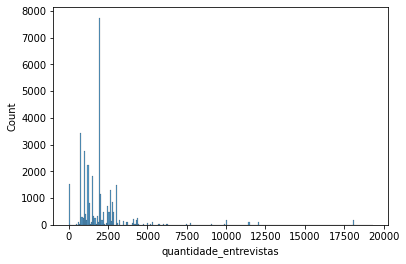

In [1028]:
# Plot Histogram
sns.histplot(pesquisas['quantidade_entrevistas'])

In [1029]:
# Medidas Descritivas
pesquisas['quantidade_entrevistas'].describe()

count    32798.000000
mean      2022.249283
std       1880.743198
min          0.000000
25%       1008.000000
50%       2000.000000
75%       2203.000000
max      19318.000000
Name: quantidade_entrevistas, dtype: float64

In [1030]:
# São dado discrepantes. Vou colocar a median por ser mais resistente a outliers: representando melhor essa variavel
pesquisas['quantidade_entrevistas'] = pesquisas['quantidade_entrevistas'].fillna(pesquisas['quantidade_entrevistas'].median())

### 2.2.7 Partido

In [1031]:
# Acredito que esse dado será importante para prever.
# Vou deixar NaN, quando tivermos feito nosso dataset final volto se necessário!

## 2.3 Inconsistent Data

### 2.3.1 Descrição Cenário

In [1032]:
pesquisas['descricao_cenario'].unique()

array(['cenário único - estimulado', 'Diversos candidatos',
       'Lula vs Serra', 'Lula vs Aécio', 'Lula vs FHC',
       'Lula vs Alckmin', 'Lula vs Garotinho',
       'intenção Lula vs Alckmin', 'Dilma vs Aécio', 'Serra vs Genro',
       'Aécio vs Genro', 'Dilma vs Serra', 'Serra vs Patrus',
       'Diversos candidatos (votos válidos)',
       'Dilma vs Aécio (votos válidos)',
       'cenário 1 - estimulada - 1° turno',
       'cenário 1 - estimulado - 1º turno',
       'cenário 1 - espontâneo - 1º turno',
       'cenário 1 - espontânea - 1º turno',
       'cenário 2 - estimulada - 1º turno',
       'cenário 3 - estimulada - 1º turno',
       'cenário 1 - estimulada - 1º turno',
       'cenário 2 - estimulada - 2º turno',
       'cenário 4 - espontânea - 1º turno',
       'cenário 2 - estimulado - 1º turno',
       'cenário 3 - estimulado - 1º turno',
       'cenário 4 - estimulado - 1º turno',
       'cenário 5 - estimulado - 1º turno',
       'cenário 6 - estimulado - 1º turno',
 

In [1033]:
# Os cenários que não existiram no segundo turno irão sumir quando fizermos nosso dataset final

In [1034]:
# Remove avaliação do governo!
pesquisas = pesquisas[~pesquisas['descricao_cenario'].str.contains('avali')]

### 2.3.2 Tipo do cenário

In [1035]:
pesquisas['tipo'].unique()

array(['estimulada', 'espontânea', 'rejeição'], dtype=object)

In [1036]:
# Não quero de rejeição
pesquisas = pesquisas[~pesquisas['tipo'].str.contains('rejei')]

### 2.3.3 Conferir conferência entre tipo_voto e desc_cenário

In [1037]:
# Verificar se os que tem entre parênteses "votos válidos" estão com o tipo do voto correto

In [1038]:
pesquisas[pesquisas['descricao_cenario'].str.contains('votos')]['tipo_voto'].unique()

array(['votos totais', 'votos válidos'], dtype=object)

Vemos aqui que não! Temos que corrigir

In [1039]:
index = pesquisas[pesquisas['descricao_cenario'].str.contains('votos')].index
pesquisas.loc[index,'tipo_voto'] = 'votos válidos'

### 2.3.4 Órgão Regulador

In [1040]:
# Quero ver se os nomes são únicos ou se há variação nos nomes
pesquisas['orgao_registro'].unique()

array(['Sem dados', 'TSE', 'TRE', 'TRE-SP', 'TRE-AL', 'TRE-PE',
       '40ª Zona Eleitoral de Betim', 'TRE-MG', 'TRE-RJ', 'TRE-ES',
       'TRE-RS', 'TRE-BA', 'TRE-DF', 'Tribunal Superior Eleitoral',
       'TRE-GO', 'TRE-CE', 'TRE-MS', 'TRE-PR', 'TRE-RN', 'TRE-AM',
       'TRE-MT', 'TRE-TO', 'TRE-MA', 'TRE-PB', 'TRE-PA', 'TRE-SE',
       'TRE-PI', 'TRE-AP', 'TRE-RO', 'TRE-RR', 'TRE/SC', 'TRE - SC',
       'n.d', 'TRE-AC'], dtype=object)

In [1041]:
index = pesquisas[pesquisas['orgao_registro'].str.contains('Tribunal Superior')].index
pesquisas.loc[index,'orgao_registro'] = 'TSE'
index = pesquisas[pesquisas['orgao_registro'].str.contains('n.d')].index
pesquisas.loc[index,'orgao_registro'] = 'Sem dados'

### 2.3.5 Contratante

In [1042]:
# Quero ver se os nomes são únicos ou se há variação nos nomes
pesquisas['contratante'].unique()

array(['Sem dados', 'Rádio e Televisão Bandeirantes Ltda', 'TV Globo',
       'Rádio e Televisão Bandeirantes', 'A Gazeta', 'TV Bandeirantes',
       'Rádio e Televisão Bandeirantes e IG',
       'O & P Brasil Opinião Análise e Estratégia', 'Jornal Opção',
       'Fortiori', 'TV Atalaia', 'Jornal da Cidade', 'Sul21', 'TV Gazeta',
       'Record TV', 'Gazeta de São Paulo', 'TV Mirante',
       'TV Rádio Clube de Teresina', 'Grupo Globo', 'NC Comunicações',
       'Centro Norte Comunicação', 'Gazeta', 'O Povo/ Folha de S/ Paulo',
       'Rede Gazeta', 'A Tarde', 'Arko Advice', 'Genial Investimentos',
       'Grupo RBS', 'Folha de S/ Paulo', 'Folha de S.Paulo', 'O Popular',
       'Jornal do Tocantins', 'ACIEG', 'Grupo Jaime Câmara',
       'J. Camara & Irmãos', 'Folha de S. Paulo e Grupo Globo',
       'Folha da Manhã', 'TV Band Paraná', 'Band Natal', 'Veritá',
       'jornal Correio do Estado', 'Paraná Pesquisas', 'Jovem Pan',
       'Band Paraná', 'Nri Serviços', 'Bahia Notícias',
    

In [1043]:
# Há bastante variação, talvez valha a pena parar um pouco aqui posteriormente.

## 2.4 Drop Irrelevant Columns

In [1044]:
# Cargo é cte, data_referencia não é a data da pesquisa e nome do candidato já tem id
pesquisas.drop(['data_referencia','nome_candidato','cargo','descricao_cenario'],1,inplace=True)

## 2.4 Data Dtypes

In [1045]:
pesquisas.dtypes

id_pesquisa                 int64
ano                         int64
data                       object
instituto                  object
contratante                object
orgao_registro             object
quantidade_entrevistas    float64
margem_mais               float64
margem_menos              float64
tipo                       object
turno                       int64
tipo_voto                  object
id_cenario                  int64
id_candidato_poder360       int64
sigla_partido              object
condicao                    int64
percentual                float64
dtype: object

In [1046]:
pesquisas['data'] = pd.to_datetime(pesquisas['data'])

In [1047]:
resultados.dtypes

nome              object
partido           object
votos            float64
votos_validos    float64
total_votos      float64
turno              int64
ano                int64
id_poder_360       int64
dtype: object

# 3.0 Feature Engineering

In [1048]:
# Local e Órgão de Registro 

pesquisas['local_registro'] = pesquisas['orgao_registro'].map({'Sem dados':'Sem dados', 'TSE':'Esfera Federal', 'TRE':'Esfera Estadual', 
        'TRE-SP':'SP', 'TRE-AL':'AL', 'TRE-PE':'PE',
       '40ª Zona Eleitoral de Betim':'MG', 'TRE-MG':'MG', 'TRE-RJ':'RJ', 'TRE-ES':'ES',
       'TRE-RS':'RS', 'TRE-BA':'BA', 'TRE-DF':'DF', 'TRE-GO':'GO', 'TRE-CE':'CE', 'TRE-MS':'MS',
       'TRE-PR':'PR', 'TRE-RN':'RN', 'TRE-AM':'AM', 'TRE-MT':'MT', 'TRE-TO':'TO', 'TRE-MA':'MA',
       'TRE-PB':'PB', 'TRE-PA':'PA', 'TRE-SE':'SE', 'TRE-PI':'PI', 'TRE-AP':'AP', 'TRE-RO':'RO',
       'TRE-RR':'RR', 'TRE/SC':'SC', 'TRE - SC':'SC', 'TRE-AC':'AC'})

pesquisas['orgao_registro'] = pesquisas['orgao_registro'].map({'Sem dados':'Sem dados', 'TSE':'TSE', 'TRE':'TRE', 
        'TRE-SP':'TRE', 'TRE-AL':'TRE', 'TRE-PE':'TRE',
       '40ª Zona Eleitoral de Betim':'Zona Eleitoral', 'TRE-MG':'TRE', 'TRE-RJ':'TRE', 'TRE-ES':'TRE',
       'TRE-RS':'TRE', 'TRE-BA':'TRE', 'TRE-DF':'TRE', 'TRE-GO':'TRE', 'TRE-CE':'TRE', 'TRE-MS':'TRE',
       'TRE-PR':'TRE', 'TRE-RN':'TRE', 'TRE-AM':'TRE', 'TRE-MT':'TRE', 'TRE-TO':'TRE', 'TRE-MA':'TRE',
       'TRE-PB':'TRE', 'TRE-PA':'TRE', 'TRE-SE':'TRE', 'TRE-PI':'TRE', 'TRE-AP':'TRE', 'TRE-RO':'TRE',
       'TRE-RR':'TRE', 'TRE/SC':'TRE', 'TRE - SC':'TRE', 'TRE-AC':'TRE'})

In [1049]:
# Pct Votos Totais/Validos
resultados['pct_votos_validos'] = resultados['votos']/resultados['votos_validos']
resultados['pct_votos_totais'] = resultados['votos']/resultados['total_votos']

In [1050]:
# Dia da Eleição (Ano e turno)

pesquisas['data_eleicao'] = np.nan

# 2006
index = pesquisas[(pesquisas['ano']==2006)&(pesquisas['turno']==1)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('01/10/2006')
index = pesquisas[(pesquisas['ano']==2006)&(pesquisas['turno']==2)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('29/10/2006')

# 2010
index = pesquisas[(pesquisas['ano']==2010)&(pesquisas['turno']==1)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('03/10/2010')
index = pesquisas[(pesquisas['ano']==2010)&(pesquisas['turno']==2)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('31/10/2010')

# 2014
index = pesquisas[(pesquisas['ano']==2014)&(pesquisas['turno']==1)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('05/10/2014')
index = pesquisas[(pesquisas['ano']==2014)&(pesquisas['turno']==2)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('26/10/2014')

# 2018
index = pesquisas[(pesquisas['ano']==2018)&(pesquisas['turno']==1)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('07/10/2018')
index = pesquisas[(pesquisas['ano']==2018)&(pesquisas['turno']==2)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('28/10/2018')

# 2022
index = pesquisas[(pesquisas['ano']==2022)&(pesquisas['turno']==1)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('02/10/2022')
index = pesquisas[(pesquisas['ano']==2022)&(pesquisas['turno']==2)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('30/10/2022')

In [1051]:
# Dias para a eleição
pesquisas['timedelta_eleicao'] = (pesquisas['data'] - pesquisas['data_eleicao']).dt.days

In [1052]:
# Meses desde o último censo
data_ultimo_censo = pesquisas['data'].dt.year.apply(lambda x: pd.to_datetime('01/12/2000') if x <= 2010 else pd.to_datetime('01/12/2010'))
pesquisas['timedelta_censo'] = (pesquisas['data'] - data_ultimo_censo).dt.days/30

# 4.0 Final Dataset

## 4.1 Left Join

In [1053]:
resultados['join_aux'] = resultados['id_poder_360'].astype('str')+resultados['ano'].astype('str')+resultados['turno'].astype('str')
pesquisas['join_aux'] = pesquisas['id_candidato_poder360'].astype('str')+pesquisas['data'].dt.year.astype('str')+pesquisas['turno'].astype('str')
dados = pd.merge(pesquisas,resultados[['pct_votos_validos','pct_votos_totais','join_aux']],on='join_aux',how='left')
dados.drop('join_aux',1,inplace=True)

## 4.2 Drop NaN Results Candidates

In [1054]:
dados = dados[~dados['pct_votos_validos'].isna()]

## 4.3 Continue Feature Engineering

In [1055]:
# Qtd de candidatos no cenario que não participaram efetivamente do pleito
aux = pesquisas.groupby('id_cenario').count()['id_candidato_poder360'].reset_index().rename(columns={'id_candidato_poder360':'qtd_candidatos'})
aux2 = dados.groupby('id_cenario').count()['id_candidato_poder360'].reset_index().rename(columns={'id_candidato_poder360':'qtd_candidatos_participaram'})
df_aux = pd.merge(aux,aux2,on='id_cenario',how='inner')
dados = pd.merge(dados,df_aux,on='id_cenario',how='left')

In [1056]:
# % Relativo dos que efetiv. concorreram
dados['pct_participacao_candidatos'] = dados['qtd_candidatos_participaram']/dados['qtd_candidatos']

In [1057]:
# % Total da Pesquisa, % dos que participaram, % dos que não participaram
aux = pesquisas.groupby('id_cenario').sum()['percentual'].reset_index().rename(columns={'percentual':'cum_cenario_pct'})
aux2 = dados.groupby('id_cenario').sum()['percentual'].reset_index().rename(columns={'percentual':'cum_cenario_pct_participaram'})
df_aux = pd.merge(aux,aux2,on='id_cenario',how='inner')
df_aux['cum_cenario_pct_nao_participaram'] = df_aux['cum_cenario_pct']-df_aux['cum_cenario_pct_participaram']
dados = pd.merge(dados,df_aux,on='id_cenario',how='left')

## 4.4 Remove 2 Turno Não Efetivado

In [1058]:
# Remove cenários 2 turno que só tem um candidato (Ex: ciro e lula em 2022, só lula foi pro 2 turno, então dropar esse cenário!)
cenarios2turno = dados[dados['turno']==2]['id_cenario'].unique()
lst = []
for cenario in cenarios2turno:
    if dados[dados['id_cenario']==cenario].shape[0] == 1:
        lst.append(cenario)
dados = dados[~dados['id_cenario'].isin(lst)]

## 4.5 Erro da Pesquisa

In [1059]:
# Real - Predito

dados.reset_index(drop=True,inplace=True)

dados['real'] = np.nan
for c in range(dados.shape[0]):
    if dados.loc[c,'tipo_voto']=='votos totais':
        dados.loc[c,'real']=dados.loc[c,'pct_votos_totais']
    elif dados.loc[c,'tipo_voto']=='votos válidos':
        dados.loc[c,'real']=dados.loc[c,'pct_votos_validos']
dados['real'] = dados['real']*100
dados['erro'] = dados['real'] - dados['percentual']

dados.drop(['pct_votos_validos','pct_votos_totais','real'],1,inplace=True)

## 4.6 Fill Partido = NaN

In [1060]:
# Fill NaN sigla partido
dados['sigla_partido'].fillna('Sem partido',inplace=True)

# 5.0 Data Preparation

## 5.1 Train Test Split (Time Series Constraint)

In [1061]:
dados = dados.sort_values('data')

train = dados[dados['ano']!=2022] # os dados anteriores a 2022 são treino
test = dados[dados['ano']==2022] # os dados de 2022 são teste

x_train,y_train = train.drop('erro',1),train['erro']
x_test,y_test = test.drop('erro',1),test['erro']

## 5.2 Drop Datetime Variables

In [1062]:
# Não vai ser útil pro modelo
x_train.drop(['data_eleicao','data'],1,inplace=True)
x_test.drop(['data_eleicao','data'],1,inplace=True)

## 5.3 Avoid data leakage and Overfitting

In [1063]:
# Não terei esses dados nem deveriam dizer nada sobre o modelo
# Talvez o modelo se fixe nele pra acertar o resultado! Então é melhor dropar
x_train.drop(['id_pesquisa','id_cenario'],1,inplace=True)
x_test.drop(['id_pesquisa','id_cenario'],1,inplace=True)

## 5.3 Encoding

In [1064]:
# Vou usar o target encoder em todos nesse momento
te = TargetEncoder()
te.fit(x_train['instituto'],y_train)
x_train['instituto'] = te.transform(x_train['instituto'])
x_test['instituto'] = te.transform(x_test['instituto'])

te.fit(x_train['contratante'],y_train)
pkl.dump(te,open('/Users/nando/labmat/trabalho/contratante_encoder.pkl','wb'))
x_train['contratante'] = te.transform(x_train['contratante'])
x_test['contratante'] = te.transform(x_test['contratante'])

te.fit(x_train['orgao_registro'],y_train)
x_train['orgao_registro'] = te.transform(x_train['orgao_registro'])
x_test['orgao_registro'] = te.transform(x_test['orgao_registro'])

te.fit(x_train['tipo'],y_train)
pkl.dump(te,open('/Users/nando/labmat/trabalho/tipo_encoder.pkl','wb'))
x_train['tipo'] = te.transform(x_train['tipo'])
x_test['tipo'] = te.transform(x_test['tipo'])

te.fit(x_train['tipo_voto'],y_train)
pkl.dump(te,open('/Users/nando/labmat/trabalho/tipo_voto_encoder.pkl','wb'))
x_train['tipo_voto'] = te.transform(x_train['tipo_voto'])
x_test['tipo_voto'] = te.transform(x_test['tipo_voto'])

te.fit(x_train['sigla_partido'],y_train)
pkl.dump(te,open('/Users/nando/labmat/trabalho/sigla_partido_encoder.pkl','wb'))
x_train['sigla_partido'] = te.transform(x_train['sigla_partido'])
x_test['sigla_partido'] = te.transform(x_test['sigla_partido'])

te.fit(x_train['local_registro'],y_train)
x_train['local_registro'] = te.transform(x_train['local_registro'])
x_test['local_registro'] = te.transform(x_test['local_registro'])

## 5.4 Feature Selection

In [1065]:
# Vou usar o Boruta com uma RandomForest para selecionar as features mais importantes
boruta = BorutaPy(RandomForestRegressor(n_jobs=-1),n_estimators='auto',verbose=2,random_state=101)
boruta.fit(np.array(x_train),np.array(y_train))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	13
Tentative: 	3
Rejected: 	7
Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	3
Rejected: 	7
Iteration: 	10 / 100
Confirmed: 	13
Tentative: 	3
Rejected: 	7
Iteration: 	11 / 100
Confirmed: 	13
Tentative: 	3
Rejected: 	7
Iteration: 	12 / 100
Confirmed: 	15
Tentative: 	1
Rejected: 	7
Iteration: 	13 / 100
Confirmed: 	15
Tentative: 	1
Rejected: 	7
Iteration: 	14 / 100
Confirmed: 	15
Tentative: 	1
Rejected: 	7
Iteration: 	15 / 100
Confirmed: 	15
Tentative: 	1
Rejected: 	7
Iteration: 	16 / 100
Confirmed: 	15
Tentative: 	0
Rejected: 	8



BorutaPy(estimator=RandomForestRegressor(n_estimators=56, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x29AAA1140),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x29AAA1140,
         verbose=2)

In [1066]:
# Colunas escolhidas
dados.drop(['data_eleicao','data','erro','id_pesquisa','id_cenario'],1).columns[boruta.support_]

Index(['ano', 'contratante', 'tipo', 'turno', 'tipo_voto',
       'id_candidato_poder360', 'sigla_partido', 'percentual',
       'timedelta_eleicao', 'timedelta_censo', 'qtd_candidatos',
       'qtd_candidatos_participaram', 'pct_participacao_candidatos',
       'cum_cenario_pct_participaram', 'cum_cenario_pct_nao_participaram'],
      dtype='object')

In [1067]:
# Colocar apenas as colunas escolhidas pelo Boruta
x_train = pd.DataFrame(x_train,columns=dados.drop(['data_eleicao','data','erro','id_pesquisa','id_cenario'],1).columns)
x_test = pd.DataFrame(x_test,columns=dados.drop(['data_eleicao','data','erro','id_pesquisa','id_cenario'],1).columns)
x_train = x_train.loc[:,boruta.support_]
x_test = x_test.loc[:,boruta.support_]

## 5.5 Reescaling

In [1068]:
# Padronização dos dados dado a grande variabilidade de escala! (vou deixar média 0 e std 1)
sc = StandardScaler()
sc.fit(x_train)
pkl.dump(sc,open('/Users/nando/labmat/trabalho/reescaler.pkl','wb'))
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

# 6.0 Model Selection and Evaluation

## 6.1 Hould Out

In [1069]:
def houldout(model):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    y_true = y_test

    mae = mean_absolute_error(y_true,y_pred)
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    print('MAE: {:.2f}\nRMSE: {:.2f}'.format(mae,rmse))

Estou usando o MAE para ter uma medida mais geral e o RMSE para ter uma medida mais conservadora, pois ao elevar os erros ao quadrado, ela dá bastante peso aos erros discrepantes, então tende a ser maior que o MAE.

### 6.1.1 Linear Regression

In [1070]:
houldout(LinearRegression())

MAE: 13.07
RMSE: 16.45


### 6.1.2 RandomForest

In [1071]:
houldout(RandomForestRegressor())

MAE: 3.14
RMSE: 6.39


### 6.1.3 XGBoost

In [1072]:
houldout(XGBRegressor())

MAE: 5.07
RMSE: 6.31


### 6.1.4 LGBM

In [1073]:
houldout(LGBMRegressor())

MAE: 4.83
RMSE: 7.29


# 7.0 Hyperparameter Finetuning

In [1080]:
# get best parameters w/ the whole dataset
x = pd.concat([pd.DataFrame(x_train),pd.DataFrame(x_test)]).reset_index(drop=True)
y = pd.concat([y_train,y_test]).reset_index(drop=True)

In [1081]:
rf = RandomForestRegressor(n_jobs=-1)
p_grid = {'n_estimators': [75,100,125,150,175,200], 'max_depth': [3,5,7,9,11,13],'min_samples_split':[2,4,6,8,10],'min_samples_leaf':[1,3,5,7,9,11]}
#p_grid = {'n_estimators': [100,200], 'max_depth': [3,5,7,9],'min_samples_split':[2,4,6],'min_samples_leaf':[1,3,5]}
search = GridSearchCV(rf,p_grid,n_jobs=-1,cv=TimeSeriesSplit(n_splits=3),scoring=['neg_mean_absolute_error','neg_root_mean_squared_error'],refit=False,verbose=3)

In [1082]:
search.fit(x,y)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits
[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; neg_mean_absolute_error: (test=-5.366) neg_root_mean_squared_error: (test=-7.890) total time=   0.6s
[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=175; neg_mean_absolute_error: (test=-5.277) neg_root_mean_squared_error: (test=-7.707) total time=   0.9s
[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=75; neg_mean_absolute_error: (test=-6.856) neg_root_mean_squared_error: (test=-8.311) total time=   0.4s
[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=125; neg_mean_absolute_error: (test=-5.315) neg_root_mean_squared_error: (test=-7.803) total time=   0.8s
[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=175; neg_mean_absolute_error: (test=-6.838) neg_root_mean_squared_error: (test=-8.299) total time=   1.5s
[CV 2/

[CV 3/3] END max_depth=3, min_samples_leaf=7, min_samples_split=6, n_estimators=125; neg_mean_absolute_error: (test=-6.870) neg_root_mean_squared_error: (test=-8.331) total time=   1.1s[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; neg_mean_absolute_error: (test=-6.873) neg_root_mean_squared_error: (test=-8.337) total time=   0.8s
[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; neg_mean_absolute_error: (test=-3.408) neg_root_mean_squared_error: (test=-5.401) total time=   0.9s
[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=100; neg_mean_absolute_error: (test=-6.886) neg_root_mean_squared_error: (test=-8.351) total time=   0.8s
[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=175; neg_mean_absolute_error: (test=-3.377) neg_root_mean_squared_error: (test=-5.354) total time=   0.6s
[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=6, n_es

[CV 1/3] END max_depth=3, min_samples_leaf=9, min_samples_split=4, n_estimators=125; neg_mean_absolute_error: (test=-3.414) neg_root_mean_squared_error: (test=-5.411) total time=   0.5s[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; neg_mean_absolute_error: (test=-3.437) neg_root_mean_squared_error: (test=-5.446) total time=   0.5s
[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=150; neg_mean_absolute_error: (test=-5.273) neg_root_mean_squared_error: (test=-7.700) total time=   0.8s
[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=75; neg_mean_absolute_error: (test=-5.330) neg_root_mean_squared_error: (test=-7.823) total time=   0.2s
[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=100; neg_mean_absolute_error: (test=-3.382) neg_root_mean_squared_error: (test=-5.383) total time=   0.4s
[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_est

[CV 2/3] END max_depth=3, min_samples_leaf=7, min_samples_split=8, n_estimators=175; neg_mean_absolute_error: (test=-5.324) neg_root_mean_squared_error: (test=-7.790) total time=   0.8s[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=125; neg_mean_absolute_error: (test=-5.234) neg_root_mean_squared_error: (test=-7.620) total time=   0.7s
[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=175; neg_mean_absolute_error: (test=-6.845) neg_root_mean_squared_error: (test=-8.297) total time=   1.5s
[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=150; neg_mean_absolute_error: (test=-5.329) neg_root_mean_squared_error: (test=-7.814) total time=   0.6s
[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=200; neg_mean_absolute_error: (test=-6.814) neg_root_mean_squared_error: (test=-8.273) total time=   1.8s
[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=6, n_es

[CV 1/3] END max_depth=3, min_samples_leaf=7, min_samples_split=10, n_estimators=175; neg_mean_absolute_error: (test=-3.405) neg_root_mean_squared_error: (test=-5.408) total time=   0.9s[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=125; neg_mean_absolute_error: (test=-3.398) neg_root_mean_squared_error: (test=-5.402) total time=   0.6s
[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=150; neg_mean_absolute_error: (test=-3.402) neg_root_mean_squared_error: (test=-5.413) total time=   0.6s
[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; neg_mean_absolute_error: (test=-5.280) neg_root_mean_squared_error: (test=-7.706) total time=   1.4s
[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=175; neg_mean_absolute_error: (test=-5.256) neg_root_mean_squared_error: (test=-7.694) total time=   0.9s
[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=6, n_e

[CV 2/3] END max_depth=3, min_samples_leaf=7, min_samples_split=10, n_estimators=100; neg_mean_absolute_error: (test=-5.285) neg_root_mean_squared_error: (test=-7.732) total time=   0.6s[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=75; neg_mean_absolute_error: (test=-3.398) neg_root_mean_squared_error: (test=-5.411) total time=   0.4s
[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=125; neg_mean_absolute_error: (test=-6.827) neg_root_mean_squared_error: (test=-8.281) total time=   0.8s
[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=75; neg_mean_absolute_error: (test=-3.388) neg_root_mean_squared_error: (test=-5.386) total time=   0.3s
[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=100; neg_mean_absolute_error: (test=-5.342) neg_root_mean_squared_error: (test=-7.855) total time=   0.4s
[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_est

[CV 2/3] END max_depth=3, min_samples_leaf=7, min_samples_split=10, n_estimators=150; neg_mean_absolute_error: (test=-5.308) neg_root_mean_squared_error: (test=-7.776) total time=   0.7s[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=75; neg_mean_absolute_error: (test=-6.785) neg_root_mean_squared_error: (test=-8.257) total time=   0.6s
[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=175; neg_mean_absolute_error: (test=-3.444) neg_root_mean_squared_error: (test=-5.444) total time=   0.7s
[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; neg_mean_absolute_error: (test=-6.825) neg_root_mean_squared_error: (test=-8.290) total time=   1.5s
[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=200; neg_mean_absolute_error: (test=-5.259) neg_root_mean_squared_error: (test=-7.672) total time=   1.3s
[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=6, n_es

[CV 2/3] END max_depth=3, min_samples_leaf=7, min_samples_split=10, n_estimators=175; neg_mean_absolute_error: (test=-5.349) neg_root_mean_squared_error: (test=-7.869) total time=   1.0s[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=75; neg_mean_absolute_error: (test=-5.232) neg_root_mean_squared_error: (test=-7.638) total time=   0.6s
[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=150; neg_mean_absolute_error: (test=-6.818) neg_root_mean_squared_error: (test=-8.282) total time=   1.2s
[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=125; neg_mean_absolute_error: (test=-3.380) neg_root_mean_squared_error: (test=-5.394) total time=   0.5s
[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=150; neg_mean_absolute_error: (test=-6.835) neg_root_mean_squared_error: (test=-8.296) total time=   1.2s
[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=6, n_es

[CV 2/3] END max_depth=3, min_samples_leaf=9, min_samples_split=4, n_estimators=200; neg_mean_absolute_error: (test=-5.331) neg_root_mean_squared_error: (test=-7.845) total time=   1.2s
[CV 3/3] END max_depth=3, min_samples_leaf=7, min_samples_split=6, n_estimators=200; neg_mean_absolute_error: (test=-6.851) neg_root_mean_squared_error: (test=-8.312) total time=   1.7s
[CV 2/3] END max_depth=3, min_samples_leaf=7, min_samples_split=8, n_estimators=200; neg_mean_absolute_error: (test=-5.244) neg_root_mean_squared_error: (test=-7.644) total time=   1.1s
[CV 3/3] END max_depth=3, min_samples_leaf=7, min_samples_split=10, n_estimators=150; neg_mean_absolute_error: (test=-6.859) neg_root_mean_squared_error: (test=-8.323) total time=   1.0s
[CV 1/3] END max_depth=3, min_samples_leaf=9, min_samples_split=2, n_estimators=100; neg_mean_absolute_error: (test=-3.360) neg_root_mean_squared_error: (test=-5.364) total time=   0.4s
[CV 1/3] END max_depth=3, min_samples_leaf=9, min_samples_split=2, n_

[CV 1/3] END max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=125; neg_mean_absolute_error: (test=-3.064) neg_root_mean_squared_error: (test=-5.255) total time=   1.0s
[CV 1/3] END max_depth=3, min_samples_leaf=7, min_samples_split=10, n_estimators=150; neg_mean_absolute_error: (test=-3.380) neg_root_mean_squared_error: (test=-5.380) total time=   0.5s
[CV 3/3] END max_depth=3, min_samples_leaf=7, min_samples_split=10, n_estimators=175; neg_mean_absolute_error: (test=-6.842) neg_root_mean_squared_error: (test=-8.299) total time=   1.4s
[CV 1/3] END max_depth=3, min_samples_leaf=9, min_samples_split=2, n_estimators=175; neg_mean_absolute_error: (test=-3.438) neg_root_mean_squared_error: (test=-5.431) total time=   0.7s
[CV 3/3] END max_depth=3, min_samples_leaf=9, min_samples_split=2, n_estimators=200; neg_mean_absolute_error: (test=-6.856) neg_root_mean_squared_error: (test=-8.313) total time=   1.9s
[CV 2/3] END max_depth=3, min_samples_leaf=9, min_samples_split=6, n

[CV 2/3] END max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=150; neg_mean_absolute_error: (test=-3.705) neg_root_mean_squared_error: (test=-5.115) total time=   2.1s
[CV 3/3] END max_depth=3, min_samples_leaf=9, min_samples_split=4, n_estimators=150; neg_mean_absolute_error: (test=-6.848) neg_root_mean_squared_error: (test=-8.310) total time=   1.3s
[CV 3/3] END max_depth=3, min_samples_leaf=9, min_samples_split=6, n_estimators=100; neg_mean_absolute_error: (test=-6.859) neg_root_mean_squared_error: (test=-8.324) total time=   0.8s
[CV 2/3] END max_depth=3, min_samples_leaf=9, min_samples_split=6, n_estimators=175; neg_mean_absolute_error: (test=-5.278) neg_root_mean_squared_error: (test=-7.720) total time=   1.1s
[CV 1/3] END max_depth=3, min_samples_leaf=9, min_samples_split=8, n_estimators=100; neg_mean_absolute_error: (test=-3.397) neg_root_mean_squared_error: (test=-5.379) total time=   0.3s
[CV 1/3] END max_depth=3, min_samples_leaf=9, min_samples_split=8, n_

[CV 3/3] END max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=75; neg_mean_absolute_error: (test=-4.657) neg_root_mean_squared_error: (test=-5.877) total time=   1.9s
[CV 3/3] END max_depth=3, min_samples_leaf=7, min_samples_split=10, n_estimators=75; neg_mean_absolute_error: (test=-6.882) neg_root_mean_squared_error: (test=-8.344) total time=   0.5s
[CV 3/3] END max_depth=3, min_samples_leaf=7, min_samples_split=10, n_estimators=125; neg_mean_absolute_error: (test=-6.845) neg_root_mean_squared_error: (test=-8.302) total time=   0.8s
[CV 2/3] END max_depth=3, min_samples_leaf=7, min_samples_split=10, n_estimators=200; neg_mean_absolute_error: (test=-5.345) neg_root_mean_squared_error: (test=-7.849) total time=   1.2s
[CV 3/3] END max_depth=3, min_samples_leaf=9, min_samples_split=2, n_estimators=150; neg_mean_absolute_error: (test=-6.838) neg_root_mean_squared_error: (test=-8.300) total time=   1.2s
[CV 2/3] END max_depth=3, min_samples_leaf=9, min_samples_split=4, n_

[CV 2/3] END max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=200; neg_mean_absolute_error: (test=-3.727) neg_root_mean_squared_error: (test=-5.144) total time=   2.9s
[CV 3/3] END max_depth=3, min_samples_leaf=7, min_samples_split=10, n_estimators=200; neg_mean_absolute_error: (test=-6.820) neg_root_mean_squared_error: (test=-8.283) total time=   1.8s
[CV 2/3] END max_depth=3, min_samples_leaf=9, min_samples_split=2, n_estimators=200; neg_mean_absolute_error: (test=-5.258) neg_root_mean_squared_error: (test=-7.686) total time=   1.3s
[CV 1/3] END max_depth=3, min_samples_leaf=9, min_samples_split=4, n_estimators=175; neg_mean_absolute_error: (test=-3.377) neg_root_mean_squared_error: (test=-5.364) total time=   0.7s
[CV 3/3] END max_depth=3, min_samples_leaf=9, min_samples_split=4, n_estimators=200; neg_mean_absolute_error: (test=-6.858) neg_root_mean_squared_error: (test=-8.321) total time=   1.8s
[CV 3/3] END max_depth=3, min_samples_leaf=9, min_samples_split=6, n_

[CV 2/3] END max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=200; neg_mean_absolute_error: (test=-3.718) neg_root_mean_squared_error: (test=-5.119) total time=   2.7s
[CV 2/3] END max_depth=3, min_samples_leaf=9, min_samples_split=2, n_estimators=75; neg_mean_absolute_error: (test=-5.320) neg_root_mean_squared_error: (test=-7.798) total time=   0.4s
[CV 3/3] END max_depth=3, min_samples_leaf=9, min_samples_split=2, n_estimators=100; neg_mean_absolute_error: (test=-6.847) neg_root_mean_squared_error: (test=-8.310) total time=   0.7s
[CV 2/3] END max_depth=3, min_samples_leaf=9, min_samples_split=2, n_estimators=175; neg_mean_absolute_error: (test=-5.289) neg_root_mean_squared_error: (test=-7.733) total time=   1.0s
[CV 3/3] END max_depth=3, min_samples_leaf=9, min_samples_split=4, n_estimators=100; neg_mean_absolute_error: (test=-6.842) neg_root_mean_squared_error: (test=-8.310) total time=   0.8s
[CV 2/3] END max_depth=3, min_samples_leaf=9, min_samples_split=4, n_e

[CV 1/3] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=150; neg_mean_absolute_error: (test=-3.059) neg_root_mean_squared_error: (test=-5.258) total time=   1.1s
[CV 2/3] END max_depth=3, min_samples_leaf=9, min_samples_split=2, n_estimators=100; neg_mean_absolute_error: (test=-5.373) neg_root_mean_squared_error: (test=-7.896) total time=   0.5s
[CV 3/3] END max_depth=3, min_samples_leaf=9, min_samples_split=2, n_estimators=125; neg_mean_absolute_error: (test=-6.852) neg_root_mean_squared_error: (test=-8.319) total time=   1.0s
[CV 1/3] END max_depth=3, min_samples_leaf=9, min_samples_split=4, n_estimators=75; neg_mean_absolute_error: (test=-3.368) neg_root_mean_squared_error: (test=-5.381) total time=   0.3s
[CV 1/3] END max_depth=3, min_samples_leaf=9, min_samples_split=4, n_estimators=100; neg_mean_absolute_error: (test=-3.356) neg_root_mean_squared_error: (test=-5.364) total time=   0.4s
[CV 2/3] END max_depth=3, min_samples_leaf=9, min_samples_split=4, n_es

[CV 3/3] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=150; neg_mean_absolute_error: (test=-4.796) neg_root_mean_squared_error: (test=-5.997) total time=   3.3s
[CV 3/3] END max_depth=3, min_samples_leaf=9, min_samples_split=6, n_estimators=150; neg_mean_absolute_error: (test=-6.847) neg_root_mean_squared_error: (test=-8.304) total time=   1.4s
[CV 3/3] END max_depth=3, min_samples_leaf=9, min_samples_split=8, n_estimators=100; neg_mean_absolute_error: (test=-6.865) neg_root_mean_squared_error: (test=-8.324) total time=   0.8s
[CV 3/3] END max_depth=3, min_samples_leaf=9, min_samples_split=8, n_estimators=175; neg_mean_absolute_error: (test=-6.817) neg_root_mean_squared_error: (test=-8.277) total time=   1.5s
[CV 1/3] END max_depth=3, min_samples_leaf=9, min_samples_split=10, n_estimators=150; neg_mean_absolute_error: (test=-3.373) neg_root_mean_squared_error: (test=-5.356) total time=   0.5s
[CV 1/3] END max_depth=3, min_samples_leaf=9, min_samples_split=10, n

[CV 3/3] END max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=100; neg_mean_absolute_error: (test=-4.764) neg_root_mean_squared_error: (test=-5.964) total time=   2.0s
[CV 2/3] END max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=150; neg_mean_absolute_error: (test=-3.720) neg_root_mean_squared_error: (test=-5.121) total time=   2.2s
[CV 3/3] END max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=200; neg_mean_absolute_error: (test=-4.787) neg_root_mean_squared_error: (test=-5.983) total time=   5.4s
[CV 3/3] END max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=200; neg_mean_absolute_error: (test=-4.775) neg_root_mean_squared_error: (test=-5.973) total time=   4.7s
[CV 1/3] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=75; neg_mean_absolute_error: (test=-3.044) neg_root_mean_squared_error: (test=-5.217) total time=   0.4s
[CV 1/3] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_es

[CV 2/3] END max_depth=5, min_samples_leaf=9, min_samples_split=10, n_estimators=100; neg_mean_absolute_error: (test=-3.823) neg_root_mean_squared_error: (test=-5.275) total time=   1.2s
[CV 3/3] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=175; neg_mean_absolute_error: (test=-4.709) neg_root_mean_squared_error: (test=-5.924) total time=   4.3s
[CV 3/3] END max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=175; neg_mean_absolute_error: (test=-4.839) neg_root_mean_squared_error: (test=-6.028) total time=   4.2s
[CV 1/3] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=175; neg_mean_absolute_error: (test=-3.058) neg_root_mean_squared_error: (test=-5.233) total time=   1.3s
[CV 2/3] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=200; neg_mean_absolute_error: (test=-3.710) neg_root_mean_squared_error: (test=-5.121) total time=   2.6s
[CV 1/3] END max_depth=5, min_samples_leaf=5, min_samples_split=4, n

[CV 3/3] END max_depth=5, min_samples_leaf=11, min_samples_split=4, n_estimators=125; neg_mean_absolute_error: (test=-4.863) neg_root_mean_squared_error: (test=-6.048) total time=   2.8s
[CV 3/3] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=150; neg_mean_absolute_error: (test=-4.815) neg_root_mean_squared_error: (test=-6.009) total time=   3.3s
[CV 1/3] END max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=125; neg_mean_absolute_error: (test=-3.058) neg_root_mean_squared_error: (test=-5.241) total time=   0.8s
[CV 3/3] END max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=125; neg_mean_absolute_error: (test=-4.932) neg_root_mean_squared_error: (test=-6.107) total time=   2.6s
[CV 1/3] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=75; neg_mean_absolute_error: (test=-3.078) neg_root_mean_squared_error: (test=-5.272) total time=   0.2s
[CV 3/3] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n

[CV 3/3] END max_depth=5, min_samples_leaf=11, min_samples_split=6, n_estimators=175; neg_mean_absolute_error: (test=-4.882) neg_root_mean_squared_error: (test=-6.065) total time=   3.8s
[CV 2/3] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=150; neg_mean_absolute_error: (test=-3.752) neg_root_mean_squared_error: (test=-5.158) total time=   2.0s
[CV 3/3] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=200; neg_mean_absolute_error: (test=-4.821) neg_root_mean_squared_error: (test=-6.012) total time=   4.7s
[CV 1/3] END max_depth=5, min_samples_leaf=5, min_samples_split=6, n_estimators=75; neg_mean_absolute_error: (test=-3.069) neg_root_mean_squared_error: (test=-5.293) total time=   0.4s
[CV 3/3] END max_depth=5, min_samples_leaf=5, min_samples_split=6, n_estimators=75; neg_mean_absolute_error: (test=-4.766) neg_root_mean_squared_error: (test=-5.967) total time=   1.6s
[CV 3/3] END max_depth=5, min_samples_leaf=5, min_samples_split=6, n_es

[CV 3/3] END max_depth=5, min_samples_leaf=11, min_samples_split=10, n_estimators=75; neg_mean_absolute_error: (test=-4.871) neg_root_mean_squared_error: (test=-6.051) total time=   1.6s
[CV 2/3] END max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=150; neg_mean_absolute_error: (test=-3.723) neg_root_mean_squared_error: (test=-5.160) total time=   2.3s
[CV 3/3] END max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=200; neg_mean_absolute_error: (test=-4.793) neg_root_mean_squared_error: (test=-5.987) total time=   4.7s
[CV 3/3] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=200; neg_mean_absolute_error: (test=-4.805) neg_root_mean_squared_error: (test=-5.997) total time=   5.0s
[CV 1/3] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100; neg_mean_absolute_error: (test=-3.078) neg_root_mean_squared_error: (test=-5.284) total time=   0.8s
[CV 1/3] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_

[CV 3/3] END max_depth=5, min_samples_leaf=11, min_samples_split=8, n_estimators=75; neg_mean_absolute_error: (test=-4.895) neg_root_mean_squared_error: (test=-6.075) total time=   1.6s
[CV 2/3] END max_depth=5, min_samples_leaf=5, min_samples_split=4, n_estimators=100; neg_mean_absolute_error: (test=-3.728) neg_root_mean_squared_error: (test=-5.158) total time=   1.4s
[CV 3/3] END max_depth=5, min_samples_leaf=5, min_samples_split=4, n_estimators=150; neg_mean_absolute_error: (test=-4.794) neg_root_mean_squared_error: (test=-5.991) total time=   3.4s
[CV 2/3] END max_depth=5, min_samples_leaf=5, min_samples_split=6, n_estimators=125; neg_mean_absolute_error: (test=-3.717) neg_root_mean_squared_error: (test=-5.117) total time=   1.4s
[CV 2/3] END max_depth=5, min_samples_leaf=5, min_samples_split=6, n_estimators=175; neg_mean_absolute_error: (test=-3.719) neg_root_mean_squared_error: (test=-5.146) total time=   2.5s
[CV 2/3] END max_depth=5, min_samples_leaf=5, min_samples_split=8, n_e

[CV 3/3] END max_depth=7, min_samples_leaf=1, min_samples_split=4, n_estimators=175; neg_mean_absolute_error: (test=-3.399) neg_root_mean_squared_error: (test=-6.220) total time=   5.4s
[CV 3/3] END max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=175; neg_mean_absolute_error: (test=-4.836) neg_root_mean_squared_error: (test=-6.028) total time=   3.7s
[CV 3/3] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=150; neg_mean_absolute_error: (test=-4.756) neg_root_mean_squared_error: (test=-5.954) total time=   4.0s
[CV 2/3] END max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=125; neg_mean_absolute_error: (test=-3.774) neg_root_mean_squared_error: (test=-5.180) total time=   1.9s
[CV 3/3] END max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=175; neg_mean_absolute_error: (test=-4.875) neg_root_mean_squared_error: (test=-6.057) total time=   4.0s
[CV 1/3] END max_depth=5, min_samples_leaf=7, min_samples_split=4, n_

[CV 1/3] END max_depth=7, min_samples_leaf=1, min_samples_split=8, n_estimators=75; neg_mean_absolute_error: (test=-2.706) neg_root_mean_squared_error: (test=-5.271) total time=   0.5s
[CV 1/3] END max_depth=5, min_samples_leaf=11, min_samples_split=8, n_estimators=175; neg_mean_absolute_error: (test=-3.054) neg_root_mean_squared_error: (test=-5.224) total time=   1.2s
[CV 2/3] END max_depth=5, min_samples_leaf=11, min_samples_split=8, n_estimators=200; neg_mean_absolute_error: (test=-3.931) neg_root_mean_squared_error: (test=-5.416) total time=   2.9s
[CV 3/3] END max_depth=5, min_samples_leaf=11, min_samples_split=10, n_estimators=150; neg_mean_absolute_error: (test=-4.767) neg_root_mean_squared_error: (test=-5.967) total time=   3.2s
[CV 3/3] END max_depth=7, min_samples_leaf=1, min_samples_split=2, n_estimators=100; neg_mean_absolute_error: (test=-3.367) neg_root_mean_squared_error: (test=-6.199) total time=   2.8s
[CV 1/3] END max_depth=7, min_samples_leaf=1, min_samples_split=2, 

[CV 2/3] END max_depth=7, min_samples_leaf=7, min_samples_split=6, n_estimators=75; neg_mean_absolute_error: (test=-3.106) neg_root_mean_squared_error: (test=-4.478) total time=   1.4s
[CV 1/3] END max_depth=5, min_samples_leaf=11, min_samples_split=6, n_estimators=100; neg_mean_absolute_error: (test=-3.080) neg_root_mean_squared_error: (test=-5.268) total time=   0.8s
[CV 2/3] END max_depth=5, min_samples_leaf=11, min_samples_split=6, n_estimators=100; neg_mean_absolute_error: (test=-3.943) neg_root_mean_squared_error: (test=-5.441) total time=   1.3s
[CV 2/3] END max_depth=5, min_samples_leaf=11, min_samples_split=6, n_estimators=150; neg_mean_absolute_error: (test=-3.900) neg_root_mean_squared_error: (test=-5.424) total time=   1.9s
[CV 3/3] END max_depth=5, min_samples_leaf=11, min_samples_split=6, n_estimators=200; neg_mean_absolute_error: (test=-4.834) neg_root_mean_squared_error: (test=-6.024) total time=   4.5s
[CV 1/3] END max_depth=5, min_samples_leaf=11, min_samples_split=10

[CV 2/3] END max_depth=7, min_samples_leaf=7, min_samples_split=4, n_estimators=125; neg_mean_absolute_error: (test=-3.096) neg_root_mean_squared_error: (test=-4.452) total time=   2.3s
[CV 1/3] END max_depth=5, min_samples_leaf=11, min_samples_split=10, n_estimators=150; neg_mean_absolute_error: (test=-3.081) neg_root_mean_squared_error: (test=-5.259) total time=   1.1s
[CV 3/3] END max_depth=5, min_samples_leaf=11, min_samples_split=10, n_estimators=175; neg_mean_absolute_error: (test=-4.743) neg_root_mean_squared_error: (test=-5.948) total time=   3.8s
[CV 2/3] END max_depth=7, min_samples_leaf=1, min_samples_split=2, n_estimators=150; neg_mean_absolute_error: (test=-2.640) neg_root_mean_squared_error: (test=-3.875) total time=   2.8s
[CV 1/3] END max_depth=7, min_samples_leaf=1, min_samples_split=4, n_estimators=75; neg_mean_absolute_error: (test=-2.655) neg_root_mean_squared_error: (test=-5.231) total time=   0.6s
[CV 1/3] END max_depth=7, min_samples_leaf=1, min_samples_split=4, 

[CV 3/3] END max_depth=7, min_samples_leaf=7, min_samples_split=10, n_estimators=100; neg_mean_absolute_error: (test=-3.314) neg_root_mean_squared_error: (test=-6.112) total time=   2.7s
[CV 3/3] END max_depth=7, min_samples_leaf=1, min_samples_split=4, n_estimators=100; neg_mean_absolute_error: (test=-3.388) neg_root_mean_squared_error: (test=-6.174) total time=   3.0s
[CV 1/3] END max_depth=7, min_samples_leaf=1, min_samples_split=4, n_estimators=200; neg_mean_absolute_error: (test=-2.644) neg_root_mean_squared_error: (test=-5.192) total time=   1.9s
[CV 1/3] END max_depth=7, min_samples_leaf=1, min_samples_split=6, n_estimators=100; neg_mean_absolute_error: (test=-2.662) neg_root_mean_squared_error: (test=-5.204) total time=   0.7s
[CV 3/3] END max_depth=7, min_samples_leaf=1, min_samples_split=6, n_estimators=100; neg_mean_absolute_error: (test=-3.386) neg_root_mean_squared_error: (test=-6.231) total time=   2.8s
[CV 1/3] END max_depth=7, min_samples_leaf=1, min_samples_split=6, n_

[CV 1/3] END max_depth=7, min_samples_leaf=7, min_samples_split=4, n_estimators=150; neg_mean_absolute_error: (test=-2.715) neg_root_mean_squared_error: (test=-5.247) total time=   1.3s
[CV 2/3] END max_depth=5, min_samples_leaf=9, min_samples_split=10, n_estimators=150; neg_mean_absolute_error: (test=-3.803) neg_root_mean_squared_error: (test=-5.228) total time=   2.1s
[CV 3/3] END max_depth=5, min_samples_leaf=9, min_samples_split=10, n_estimators=200; neg_mean_absolute_error: (test=-4.785) neg_root_mean_squared_error: (test=-5.981) total time=   4.4s
[CV 1/3] END max_depth=5, min_samples_leaf=11, min_samples_split=4, n_estimators=75; neg_mean_absolute_error: (test=-3.085) neg_root_mean_squared_error: (test=-5.261) total time=   0.3s
[CV 3/3] END max_depth=5, min_samples_leaf=11, min_samples_split=4, n_estimators=75; neg_mean_absolute_error: (test=-4.730) neg_root_mean_squared_error: (test=-5.942) total time=   1.8s
[CV 1/3] END max_depth=5, min_samples_leaf=11, min_samples_split=4, 

[CV 1/3] END max_depth=7, min_samples_leaf=9, min_samples_split=6, n_estimators=100; neg_mean_absolute_error: (test=-2.693) neg_root_mean_squared_error: (test=-5.210) total time=   1.0s
[CV 1/3] END max_depth=5, min_samples_leaf=11, min_samples_split=8, n_estimators=150; neg_mean_absolute_error: (test=-3.048) neg_root_mean_squared_error: (test=-5.235) total time=   1.1s
[CV 3/3] END max_depth=5, min_samples_leaf=11, min_samples_split=8, n_estimators=175; neg_mean_absolute_error: (test=-4.828) neg_root_mean_squared_error: (test=-6.023) total time=   4.1s
[CV 1/3] END max_depth=5, min_samples_leaf=11, min_samples_split=10, n_estimators=175; neg_mean_absolute_error: (test=-3.047) neg_root_mean_squared_error: (test=-5.224) total time=   1.2s
[CV 3/3] END max_depth=5, min_samples_leaf=11, min_samples_split=10, n_estimators=200; neg_mean_absolute_error: (test=-4.780) neg_root_mean_squared_error: (test=-5.978) total time=   4.3s
[CV 2/3] END max_depth=7, min_samples_leaf=1, min_samples_split=

[CV 2/3] END max_depth=7, min_samples_leaf=9, min_samples_split=4, n_estimators=125; neg_mean_absolute_error: (test=-3.159) neg_root_mean_squared_error: (test=-4.528) total time=   2.1s
[CV 3/3] END max_depth=7, min_samples_leaf=1, min_samples_split=8, n_estimators=75; neg_mean_absolute_error: (test=-3.394) neg_root_mean_squared_error: (test=-6.271) total time=   2.2s
[CV 3/3] END max_depth=7, min_samples_leaf=1, min_samples_split=8, n_estimators=125; neg_mean_absolute_error: (test=-3.376) neg_root_mean_squared_error: (test=-6.163) total time=   3.6s
[CV 3/3] END max_depth=7, min_samples_leaf=1, min_samples_split=10, n_estimators=75; neg_mean_absolute_error: (test=-3.357) neg_root_mean_squared_error: (test=-6.139) total time=   2.1s
[CV 3/3] END max_depth=7, min_samples_leaf=1, min_samples_split=10, n_estimators=125; neg_mean_absolute_error: (test=-3.408) neg_root_mean_squared_error: (test=-6.187) total time=   3.5s
[CV 3/3] END max_depth=7, min_samples_leaf=3, min_samples_split=2, n_e

[CV 1/3] END max_depth=7, min_samples_leaf=9, min_samples_split=6, n_estimators=200; neg_mean_absolute_error: (test=-2.697) neg_root_mean_squared_error: (test=-5.210) total time=   1.8s
[CV 3/3] END max_depth=7, min_samples_leaf=7, min_samples_split=4, n_estimators=175; neg_mean_absolute_error: (test=-3.329) neg_root_mean_squared_error: (test=-6.082) total time=   5.0s
[CV 1/3] END max_depth=7, min_samples_leaf=7, min_samples_split=6, n_estimators=175; neg_mean_absolute_error: (test=-2.718) neg_root_mean_squared_error: (test=-5.276) total time=   1.5s
[CV 2/3] END max_depth=7, min_samples_leaf=7, min_samples_split=6, n_estimators=200; neg_mean_absolute_error: (test=-3.093) neg_root_mean_squared_error: (test=-4.457) total time=   3.8s
[CV 3/3] END max_depth=7, min_samples_leaf=7, min_samples_split=8, n_estimators=150; neg_mean_absolute_error: (test=-3.331) neg_root_mean_squared_error: (test=-6.152) total time=   4.4s
[CV 1/3] END max_depth=7, min_samples_leaf=7, min_samples_split=10, n_

[CV 1/3] END max_depth=9, min_samples_leaf=3, min_samples_split=2, n_estimators=150; neg_mean_absolute_error: (test=-2.507) neg_root_mean_squared_error: (test=-5.282) total time=   1.4s
[CV 1/3] END max_depth=7, min_samples_leaf=7, min_samples_split=6, n_estimators=125; neg_mean_absolute_error: (test=-2.698) neg_root_mean_squared_error: (test=-5.234) total time=   1.0s
[CV 1/3] END max_depth=7, min_samples_leaf=7, min_samples_split=6, n_estimators=150; neg_mean_absolute_error: (test=-2.695) neg_root_mean_squared_error: (test=-5.221) total time=   1.2s
[CV 2/3] END max_depth=7, min_samples_leaf=7, min_samples_split=6, n_estimators=175; neg_mean_absolute_error: (test=-3.074) neg_root_mean_squared_error: (test=-4.440) total time=   3.2s
[CV 3/3] END max_depth=7, min_samples_leaf=7, min_samples_split=8, n_estimators=100; neg_mean_absolute_error: (test=-3.321) neg_root_mean_squared_error: (test=-6.142) total time=   3.0s
[CV 1/3] END max_depth=7, min_samples_leaf=7, min_samples_split=8, n_e

[CV 1/3] END max_depth=7, min_samples_leaf=9, min_samples_split=2, n_estimators=200; neg_mean_absolute_error: (test=-2.711) neg_root_mean_squared_error: (test=-5.234) total time=   1.7s
[CV 3/3] END max_depth=7, min_samples_leaf=9, min_samples_split=4, n_estimators=75; neg_mean_absolute_error: (test=-3.342) neg_root_mean_squared_error: (test=-6.172) total time=   2.1s
[CV 3/3] END max_depth=7, min_samples_leaf=9, min_samples_split=4, n_estimators=125; neg_mean_absolute_error: (test=-3.415) neg_root_mean_squared_error: (test=-6.241) total time=   3.6s
[CV 3/3] END max_depth=7, min_samples_leaf=9, min_samples_split=6, n_estimators=75; neg_mean_absolute_error: (test=-3.304) neg_root_mean_squared_error: (test=-6.124) total time=   2.2s
[CV 3/3] END max_depth=7, min_samples_leaf=9, min_samples_split=6, n_estimators=125; neg_mean_absolute_error: (test=-3.325) neg_root_mean_squared_error: (test=-6.093) total time=   3.6s
[CV 3/3] END max_depth=7, min_samples_leaf=9, min_samples_split=8, n_est

[CV 1/3] END max_depth=7, min_samples_leaf=9, min_samples_split=4, n_estimators=125; neg_mean_absolute_error: (test=-2.719) neg_root_mean_squared_error: (test=-5.269) total time=   1.0s
[CV 1/3] END max_depth=7, min_samples_leaf=9, min_samples_split=4, n_estimators=150; neg_mean_absolute_error: (test=-2.696) neg_root_mean_squared_error: (test=-5.214) total time=   1.3s
[CV 2/3] END max_depth=7, min_samples_leaf=9, min_samples_split=4, n_estimators=175; neg_mean_absolute_error: (test=-3.194) neg_root_mean_squared_error: (test=-4.569) total time=   3.1s
[CV 2/3] END max_depth=7, min_samples_leaf=9, min_samples_split=6, n_estimators=100; neg_mean_absolute_error: (test=-3.155) neg_root_mean_squared_error: (test=-4.515) total time=   1.6s
[CV 3/3] END max_depth=7, min_samples_leaf=9, min_samples_split=6, n_estimators=150; neg_mean_absolute_error: (test=-3.324) neg_root_mean_squared_error: (test=-6.141) total time=   4.4s
[CV 2/3] END max_depth=7, min_samples_leaf=9, min_samples_split=8, n_e

[CV 1/3] END max_depth=7, min_samples_leaf=11, min_samples_split=6, n_estimators=125; neg_mean_absolute_error: (test=-2.718) neg_root_mean_squared_error: (test=-5.247) total time=   1.1s
[CV 1/3] END max_depth=7, min_samples_leaf=11, min_samples_split=6, n_estimators=150; neg_mean_absolute_error: (test=-2.733) neg_root_mean_squared_error: (test=-5.263) total time=   1.0s
[CV 2/3] END max_depth=7, min_samples_leaf=11, min_samples_split=6, n_estimators=175; neg_mean_absolute_error: (test=-3.324) neg_root_mean_squared_error: (test=-4.784) total time=   3.2s
[CV 2/3] END max_depth=7, min_samples_leaf=11, min_samples_split=8, n_estimators=100; neg_mean_absolute_error: (test=-3.299) neg_root_mean_squared_error: (test=-4.770) total time=   1.6s
[CV 2/3] END max_depth=7, min_samples_leaf=11, min_samples_split=8, n_estimators=150; neg_mean_absolute_error: (test=-3.323) neg_root_mean_squared_error: (test=-4.758) total time=   2.6s
[CV 3/3] END max_depth=7, min_samples_leaf=11, min_samples_split=

[CV 2/3] END max_depth=9, min_samples_leaf=1, min_samples_split=8, n_estimators=75; neg_mean_absolute_error: (test=-2.211) neg_root_mean_squared_error: (test=-3.557) total time=   1.5s
[CV 1/3] END max_depth=9, min_samples_leaf=1, min_samples_split=8, n_estimators=125; neg_mean_absolute_error: (test=-2.463) neg_root_mean_squared_error: (test=-5.210) total time=   1.1s
[CV 3/3] END max_depth=9, min_samples_leaf=1, min_samples_split=8, n_estimators=125; neg_mean_absolute_error: (test=-3.363) neg_root_mean_squared_error: (test=-6.386) total time=   4.3s
[CV 2/3] END max_depth=9, min_samples_leaf=1, min_samples_split=10, n_estimators=75; neg_mean_absolute_error: (test=-2.186) neg_root_mean_squared_error: (test=-3.542) total time=   1.6s
[CV 1/3] END max_depth=9, min_samples_leaf=1, min_samples_split=10, n_estimators=125; neg_mean_absolute_error: (test=-2.464) neg_root_mean_squared_error: (test=-5.184) total time=   1.2s
[CV 3/3] END max_depth=9, min_samples_leaf=1, min_samples_split=10, n_

[CV 2/3] END max_depth=9, min_samples_leaf=5, min_samples_split=8, n_estimators=125; neg_mean_absolute_error: (test=-2.483) neg_root_mean_squared_error: (test=-3.861) total time=   2.6s
[CV 2/3] END max_depth=7, min_samples_leaf=9, min_samples_split=8, n_estimators=75; neg_mean_absolute_error: (test=-3.173) neg_root_mean_squared_error: (test=-4.574) total time=   1.2s
[CV 1/3] END max_depth=7, min_samples_leaf=9, min_samples_split=8, n_estimators=125; neg_mean_absolute_error: (test=-2.689) neg_root_mean_squared_error: (test=-5.215) total time=   1.0s
[CV 3/3] END max_depth=7, min_samples_leaf=9, min_samples_split=8, n_estimators=125; neg_mean_absolute_error: (test=-3.430) neg_root_mean_squared_error: (test=-6.231) total time=   3.5s
[CV 3/3] END max_depth=7, min_samples_leaf=9, min_samples_split=10, n_estimators=75; neg_mean_absolute_error: (test=-3.404) neg_root_mean_squared_error: (test=-6.234) total time=   2.2s
[CV 1/3] END max_depth=7, min_samples_leaf=9, min_samples_split=10, n_e

[CV 3/3] END max_depth=9, min_samples_leaf=5, min_samples_split=8, n_estimators=150; neg_mean_absolute_error: (test=-3.274) neg_root_mean_squared_error: (test=-6.063) total time=   5.3s
[CV 2/3] END max_depth=9, min_samples_leaf=3, min_samples_split=2, n_estimators=175; neg_mean_absolute_error: (test=-2.256) neg_root_mean_squared_error: (test=-3.580) total time=   3.9s
[CV 2/3] END max_depth=9, min_samples_leaf=3, min_samples_split=4, n_estimators=100; neg_mean_absolute_error: (test=-2.280) neg_root_mean_squared_error: (test=-3.613) total time=   2.3s
[CV 3/3] END max_depth=9, min_samples_leaf=3, min_samples_split=4, n_estimators=150; neg_mean_absolute_error: (test=-3.321) neg_root_mean_squared_error: (test=-6.195) total time=   5.3s
[CV 1/3] END max_depth=9, min_samples_leaf=3, min_samples_split=6, n_estimators=125; neg_mean_absolute_error: (test=-2.478) neg_root_mean_squared_error: (test=-5.228) total time=   1.1s
[CV 1/3] END max_depth=9, min_samples_leaf=3, min_samples_split=6, n_e

[CV 2/3] END max_depth=9, min_samples_leaf=9, min_samples_split=8, n_estimators=150; neg_mean_absolute_error: (test=-2.737) neg_root_mean_squared_error: (test=-4.209) total time=   3.1s
[CV 3/3] END max_depth=9, min_samples_leaf=3, min_samples_split=8, n_estimators=100; neg_mean_absolute_error: (test=-3.188) neg_root_mean_squared_error: (test=-6.059) total time=   3.6s
[CV 1/3] END max_depth=9, min_samples_leaf=3, min_samples_split=8, n_estimators=200; neg_mean_absolute_error: (test=-2.521) neg_root_mean_squared_error: (test=-5.275) total time=   1.9s
[CV 1/3] END max_depth=9, min_samples_leaf=3, min_samples_split=10, n_estimators=75; neg_mean_absolute_error: (test=-2.518) neg_root_mean_squared_error: (test=-5.220) total time=   0.7s
[CV 1/3] END max_depth=9, min_samples_leaf=3, min_samples_split=10, n_estimators=100; neg_mean_absolute_error: (test=-2.489) neg_root_mean_squared_error: (test=-5.251) total time=   0.9s
[CV 3/3] END max_depth=9, min_samples_leaf=3, min_samples_split=10, n

[CV 2/3] END max_depth=9, min_samples_leaf=11, min_samples_split=4, n_estimators=75; neg_mean_absolute_error: (test=-2.902) neg_root_mean_squared_error: (test=-4.415) total time=   1.5s
[CV 3/3] END max_depth=9, min_samples_leaf=3, min_samples_split=10, n_estimators=125; neg_mean_absolute_error: (test=-3.247) neg_root_mean_squared_error: (test=-6.163) total time=   4.3s
[CV 2/3] END max_depth=9, min_samples_leaf=5, min_samples_split=2, n_estimators=75; neg_mean_absolute_error: (test=-2.503) neg_root_mean_squared_error: (test=-3.886) total time=   1.5s
[CV 1/3] END max_depth=9, min_samples_leaf=5, min_samples_split=2, n_estimators=125; neg_mean_absolute_error: (test=-2.514) neg_root_mean_squared_error: (test=-5.230) total time=   1.2s
[CV 3/3] END max_depth=9, min_samples_leaf=5, min_samples_split=2, n_estimators=125; neg_mean_absolute_error: (test=-3.266) neg_root_mean_squared_error: (test=-6.119) total time=   4.3s
[CV 3/3] END max_depth=9, min_samples_leaf=5, min_samples_split=4, n_e

[CV 2/3] END max_depth=9, min_samples_leaf=11, min_samples_split=6, n_estimators=100; neg_mean_absolute_error: (test=-2.879) neg_root_mean_squared_error: (test=-4.424) total time=   1.9s[CV 3/3] END max_depth=9, min_samples_leaf=3, min_samples_split=2, n_estimators=100; neg_mean_absolute_error: (test=-3.247) neg_root_mean_squared_error: (test=-6.168) total time=   3.5s
[CV 1/3] END max_depth=9, min_samples_leaf=3, min_samples_split=2, n_estimators=200; neg_mean_absolute_error: (test=-2.501) neg_root_mean_squared_error: (test=-5.272) total time=   2.1s
[CV 3/3] END max_depth=9, min_samples_leaf=3, min_samples_split=4, n_estimators=75; neg_mean_absolute_error: (test=-3.221) neg_root_mean_squared_error: (test=-6.099) total time=   2.7s
[CV 3/3] END max_depth=9, min_samples_leaf=3, min_samples_split=4, n_estimators=125; neg_mean_absolute_error: (test=-3.236) neg_root_mean_squared_error: (test=-6.114) total time=   4.4s
[CV 3/3] END max_depth=9, min_samples_leaf=3, min_samples_split=6, n_es

[CV 2/3] END max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=175; neg_mean_absolute_error: (test=-2.905) neg_root_mean_squared_error: (test=-4.394) total time=   3.8s
[CV 3/3] END max_depth=9, min_samples_leaf=5, min_samples_split=8, n_estimators=175; neg_mean_absolute_error: (test=-3.281) neg_root_mean_squared_error: (test=-6.086) total time=   6.7s
[CV 1/3] END max_depth=9, min_samples_leaf=5, min_samples_split=10, n_estimators=175; neg_mean_absolute_error: (test=-2.503) neg_root_mean_squared_error: (test=-5.209) total time=   1.6s
[CV 2/3] END max_depth=9, min_samples_leaf=5, min_samples_split=10, n_estimators=200; neg_mean_absolute_error: (test=-2.493) neg_root_mean_squared_error: (test=-3.891) total time=   4.6s
[CV 2/3] END max_depth=9, min_samples_leaf=7, min_samples_split=2, n_estimators=150; neg_mean_absolute_error: (test=-2.672) neg_root_mean_squared_error: (test=-4.130) total time=   3.1s
[CV 3/3] END max_depth=9, min_samples_leaf=7, min_samples_split=2, 

[CV 1/3] END max_depth=11, min_samples_leaf=1, min_samples_split=6, n_estimators=125; neg_mean_absolute_error: (test=-2.320) neg_root_mean_squared_error: (test=-5.137) total time=   1.5s
[CV 1/3] END max_depth=9, min_samples_leaf=3, min_samples_split=6, n_estimators=175; neg_mean_absolute_error: (test=-2.496) neg_root_mean_squared_error: (test=-5.241) total time=   1.9s
[CV 2/3] END max_depth=9, min_samples_leaf=3, min_samples_split=6, n_estimators=200; neg_mean_absolute_error: (test=-2.261) neg_root_mean_squared_error: (test=-3.603) total time=   4.4s
[CV 1/3] END max_depth=9, min_samples_leaf=3, min_samples_split=8, n_estimators=150; neg_mean_absolute_error: (test=-2.521) neg_root_mean_squared_error: (test=-5.282) total time=   1.5s
[CV 2/3] END max_depth=9, min_samples_leaf=3, min_samples_split=8, n_estimators=175; neg_mean_absolute_error: (test=-2.290) neg_root_mean_squared_error: (test=-3.637) total time=   3.9s
[CV 2/3] END max_depth=9, min_samples_leaf=3, min_samples_split=10, n

[CV 2/3] END max_depth=9, min_samples_leaf=11, min_samples_split=6, n_estimators=200; neg_mean_absolute_error: (test=-2.895) neg_root_mean_squared_error: (test=-4.426) total time=   4.4s
[CV 1/3] END max_depth=9, min_samples_leaf=3, min_samples_split=10, n_estimators=150; neg_mean_absolute_error: (test=-2.504) neg_root_mean_squared_error: (test=-5.248) total time=   1.6s
[CV 3/3] END max_depth=9, min_samples_leaf=3, min_samples_split=10, n_estimators=175; neg_mean_absolute_error: (test=-3.237) neg_root_mean_squared_error: (test=-6.122) total time=   6.2s
[CV 1/3] END max_depth=9, min_samples_leaf=5, min_samples_split=2, n_estimators=175; neg_mean_absolute_error: (test=-2.504) neg_root_mean_squared_error: (test=-5.231) total time=   1.9s
[CV 2/3] END max_depth=9, min_samples_leaf=5, min_samples_split=2, n_estimators=200; neg_mean_absolute_error: (test=-2.471) neg_root_mean_squared_error: (test=-3.880) total time=   4.5s
[CV 2/3] END max_depth=9, min_samples_leaf=5, min_samples_split=4, 

[CV 2/3] END max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=175; neg_mean_absolute_error: (test=-1.734) neg_root_mean_squared_error: (test=-3.041) total time=   4.5s
[CV 2/3] END max_depth=9, min_samples_leaf=5, min_samples_split=10, n_estimators=125; neg_mean_absolute_error: (test=-2.515) neg_root_mean_squared_error: (test=-3.909) total time=   2.8s
[CV 2/3] END max_depth=9, min_samples_leaf=5, min_samples_split=10, n_estimators=175; neg_mean_absolute_error: (test=-2.478) neg_root_mean_squared_error: (test=-3.873) total time=   3.9s
[CV 2/3] END max_depth=9, min_samples_leaf=7, min_samples_split=2, n_estimators=100; neg_mean_absolute_error: (test=-2.685) neg_root_mean_squared_error: (test=-4.134) total time=   2.0s
[CV 3/3] END max_depth=9, min_samples_leaf=7, min_samples_split=2, n_estimators=150; neg_mean_absolute_error: (test=-3.346) neg_root_mean_squared_error: (test=-6.125) total time=   5.4s
[CV 2/3] END max_depth=9, min_samples_leaf=7, min_samples_split=4, 

[CV 2/3] END max_depth=11, min_samples_leaf=3, min_samples_split=4, n_estimators=125; neg_mean_absolute_error: (test=-2.004) neg_root_mean_squared_error: (test=-3.358) total time=   3.0s
[CV 1/3] END max_depth=9, min_samples_leaf=11, min_samples_split=4, n_estimators=125; neg_mean_absolute_error: (test=-2.585) neg_root_mean_squared_error: (test=-5.208) total time=   1.3s
[CV 3/3] END max_depth=9, min_samples_leaf=11, min_samples_split=4, n_estimators=125; neg_mean_absolute_error: (test=-3.296) neg_root_mean_squared_error: (test=-6.074) total time=   4.2s
[CV 3/3] END max_depth=9, min_samples_leaf=11, min_samples_split=6, n_estimators=75; neg_mean_absolute_error: (test=-3.404) neg_root_mean_squared_error: (test=-6.083) total time=   2.7s
[CV 1/3] END max_depth=9, min_samples_leaf=11, min_samples_split=6, n_estimators=150; neg_mean_absolute_error: (test=-2.566) neg_root_mean_squared_error: (test=-5.201) total time=   1.3s
[CV 2/3] END max_depth=9, min_samples_leaf=11, min_samples_split=6

[CV 3/3] END max_depth=11, min_samples_leaf=5, min_samples_split=6, n_estimators=125; neg_mean_absolute_error: (test=-3.161) neg_root_mean_squared_error: (test=-5.998) total time=   4.9s
[CV 1/3] END max_depth=9, min_samples_leaf=9, min_samples_split=10, n_estimators=75; neg_mean_absolute_error: (test=-2.544) neg_root_mean_squared_error: (test=-5.191) total time=   0.6s
[CV 3/3] END max_depth=9, min_samples_leaf=9, min_samples_split=10, n_estimators=75; neg_mean_absolute_error: (test=-3.341) neg_root_mean_squared_error: (test=-6.129) total time=   2.7s
[CV 3/3] END max_depth=9, min_samples_leaf=9, min_samples_split=10, n_estimators=125; neg_mean_absolute_error: (test=-3.330) neg_root_mean_squared_error: (test=-6.102) total time=   4.3s
[CV 1/3] END max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=100; neg_mean_absolute_error: (test=-2.566) neg_root_mean_squared_error: (test=-5.187) total time=   0.8s
[CV 3/3] END max_depth=9, min_samples_leaf=11, min_samples_split=2,

[CV 1/3] END max_depth=11, min_samples_leaf=5, min_samples_split=4, n_estimators=150; neg_mean_absolute_error: (test=-2.371) neg_root_mean_squared_error: (test=-5.145) total time=   1.6s
[CV 2/3] END max_depth=9, min_samples_leaf=11, min_samples_split=6, n_estimators=150; neg_mean_absolute_error: (test=-2.861) neg_root_mean_squared_error: (test=-4.373) total time=   3.3s
[CV 1/3] END max_depth=9, min_samples_leaf=11, min_samples_split=8, n_estimators=75; neg_mean_absolute_error: (test=-2.598) neg_root_mean_squared_error: (test=-5.202) total time=   0.6s
[CV 3/3] END max_depth=9, min_samples_leaf=11, min_samples_split=8, n_estimators=75; neg_mean_absolute_error: (test=-3.372) neg_root_mean_squared_error: (test=-6.122) total time=   2.5s
[CV 1/3] END max_depth=9, min_samples_leaf=11, min_samples_split=8, n_estimators=150; neg_mean_absolute_error: (test=-2.559) neg_root_mean_squared_error: (test=-5.194) total time=   1.4s
[CV 2/3] END max_depth=9, min_samples_leaf=11, min_samples_split=8,

[CV 1/3] END max_depth=11, min_samples_leaf=5, min_samples_split=10, n_estimators=100; neg_mean_absolute_error: (test=-2.344) neg_root_mean_squared_error: (test=-5.152) total time=   0.9s
[CV 2/3] END max_depth=9, min_samples_leaf=11, min_samples_split=4, n_estimators=100; neg_mean_absolute_error: (test=-2.925) neg_root_mean_squared_error: (test=-4.499) total time=   2.2s
[CV 3/3] END max_depth=9, min_samples_leaf=11, min_samples_split=4, n_estimators=150; neg_mean_absolute_error: (test=-3.325) neg_root_mean_squared_error: (test=-6.090) total time=   5.2s
[CV 2/3] END max_depth=9, min_samples_leaf=11, min_samples_split=6, n_estimators=125; neg_mean_absolute_error: (test=-2.922) neg_root_mean_squared_error: (test=-4.384) total time=   2.5s
[CV 3/3] END max_depth=9, min_samples_leaf=11, min_samples_split=6, n_estimators=175; neg_mean_absolute_error: (test=-3.354) neg_root_mean_squared_error: (test=-6.171) total time=   6.3s
[CV 1/3] END max_depth=9, min_samples_leaf=11, min_samples_split

[CV 3/3] END max_depth=11, min_samples_leaf=7, min_samples_split=4, n_estimators=150; neg_mean_absolute_error: (test=-3.311) neg_root_mean_squared_error: (test=-6.131) total time=   5.9s
[CV 1/3] END max_depth=11, min_samples_leaf=1, min_samples_split=6, n_estimators=150; neg_mean_absolute_error: (test=-2.325) neg_root_mean_squared_error: (test=-5.166) total time=   1.8s
[CV 3/3] END max_depth=11, min_samples_leaf=1, min_samples_split=6, n_estimators=175; neg_mean_absolute_error: (test=-3.175) neg_root_mean_squared_error: (test=-6.307) total time=   7.5s
[CV 1/3] END max_depth=11, min_samples_leaf=1, min_samples_split=8, n_estimators=175; neg_mean_absolute_error: (test=-2.347) neg_root_mean_squared_error: (test=-5.162) total time=   2.1s
[CV 2/3] END max_depth=11, min_samples_leaf=1, min_samples_split=8, n_estimators=200; neg_mean_absolute_error: (test=-1.809) neg_root_mean_squared_error: (test=-3.198) total time=   5.2s
[CV 2/3] END max_depth=11, min_samples_leaf=1, min_samples_split=

[CV 2/3] END max_depth=11, min_samples_leaf=7, min_samples_split=10, n_estimators=200; neg_mean_absolute_error: (test=-2.442) neg_root_mean_squared_error: (test=-3.943) total time=   4.9s
[CV 2/3] END max_depth=9, min_samples_leaf=11, min_samples_split=8, n_estimators=150; neg_mean_absolute_error: (test=-2.905) neg_root_mean_squared_error: (test=-4.430) total time=   3.2s
[CV 3/3] END max_depth=9, min_samples_leaf=11, min_samples_split=8, n_estimators=200; neg_mean_absolute_error: (test=-3.392) neg_root_mean_squared_error: (test=-6.153) total time=   7.1s
[CV 1/3] END max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=75; neg_mean_absolute_error: (test=-2.288) neg_root_mean_squared_error: (test=-5.152) total time=   1.0s
[CV 1/3] END max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=100; neg_mean_absolute_error: (test=-2.358) neg_root_mean_squared_error: (test=-5.196) total time=   1.2s
[CV 2/3] END max_depth=11, min_samples_leaf=1, min_samples_split=

[CV 2/3] END max_depth=11, min_samples_leaf=9, min_samples_split=4, n_estimators=175; neg_mean_absolute_error: (test=-2.523) neg_root_mean_squared_error: (test=-3.999) total time=   4.5s
[CV 3/3] END max_depth=11, min_samples_leaf=3, min_samples_split=4, n_estimators=175; neg_mean_absolute_error: (test=-3.040) neg_root_mean_squared_error: (test=-6.074) total time=   7.4s
[CV 1/3] END max_depth=11, min_samples_leaf=3, min_samples_split=6, n_estimators=175; neg_mean_absolute_error: (test=-2.344) neg_root_mean_squared_error: (test=-5.137) total time=   1.9s
[CV 2/3] END max_depth=11, min_samples_leaf=3, min_samples_split=6, n_estimators=200; neg_mean_absolute_error: (test=-2.002) neg_root_mean_squared_error: (test=-3.387) total time=   5.0s
[CV 2/3] END max_depth=11, min_samples_leaf=3, min_samples_split=8, n_estimators=150; neg_mean_absolute_error: (test=-2.048) neg_root_mean_squared_error: (test=-3.421) total time=   3.8s
[CV 3/3] END max_depth=11, min_samples_leaf=3, min_samples_split=

[CV 2/3] END max_depth=11, min_samples_leaf=11, min_samples_split=6, n_estimators=200; neg_mean_absolute_error: (test=-2.754) neg_root_mean_squared_error: (test=-4.322) total time=   4.7s
[CV 1/3] END max_depth=11, min_samples_leaf=5, min_samples_split=8, n_estimators=75; neg_mean_absolute_error: (test=-2.395) neg_root_mean_squared_error: (test=-5.204) total time=   1.0s
[CV 1/3] END max_depth=11, min_samples_leaf=5, min_samples_split=8, n_estimators=100; neg_mean_absolute_error: (test=-2.356) neg_root_mean_squared_error: (test=-5.146) total time=   0.9s
[CV 3/3] END max_depth=11, min_samples_leaf=5, min_samples_split=8, n_estimators=100; neg_mean_absolute_error: (test=-3.097) neg_root_mean_squared_error: (test=-5.987) total time=   4.0s
[CV 1/3] END max_depth=11, min_samples_leaf=5, min_samples_split=8, n_estimators=200; neg_mean_absolute_error: (test=-2.348) neg_root_mean_squared_error: (test=-5.139) total time=   2.1s
[CV 2/3] END max_depth=11, min_samples_leaf=5, min_samples_split=

[CV 1/3] END max_depth=13, min_samples_leaf=1, min_samples_split=4, n_estimators=75; neg_mean_absolute_error: (test=-2.290) neg_root_mean_squared_error: (test=-5.168) total time=   0.8s
[CV 2/3] END max_depth=11, min_samples_leaf=5, min_samples_split=4, n_estimators=175; neg_mean_absolute_error: (test=-2.316) neg_root_mean_squared_error: (test=-3.743) total time=   4.3s
[CV 2/3] END max_depth=11, min_samples_leaf=5, min_samples_split=6, n_estimators=100; neg_mean_absolute_error: (test=-2.319) neg_root_mean_squared_error: (test=-3.717) total time=   2.6s
[CV 3/3] END max_depth=11, min_samples_leaf=5, min_samples_split=6, n_estimators=150; neg_mean_absolute_error: (test=-3.179) neg_root_mean_squared_error: (test=-6.014) total time=   6.1s
[CV 2/3] END max_depth=11, min_samples_leaf=5, min_samples_split=8, n_estimators=125; neg_mean_absolute_error: (test=-2.270) neg_root_mean_squared_error: (test=-3.693) total time=   3.1s
[CV 3/3] END max_depth=11, min_samples_leaf=5, min_samples_split=8

[CV 3/3] END max_depth=13, min_samples_leaf=1, min_samples_split=6, n_estimators=200; neg_mean_absolute_error: (test=-3.142) neg_root_mean_squared_error: (test=-6.328) total time=   9.1s
[CV 2/3] END max_depth=11, min_samples_leaf=9, min_samples_split=2, n_estimators=150; neg_mean_absolute_error: (test=-2.542) neg_root_mean_squared_error: (test=-4.030) total time=   3.6s
[CV 3/3] END max_depth=11, min_samples_leaf=9, min_samples_split=2, n_estimators=200; neg_mean_absolute_error: (test=-3.311) neg_root_mean_squared_error: (test=-6.144) total time=   8.5s
[CV 2/3] END max_depth=11, min_samples_leaf=9, min_samples_split=6, n_estimators=75; neg_mean_absolute_error: (test=-2.575) neg_root_mean_squared_error: (test=-4.075) total time=   1.7s
[CV 3/3] END max_depth=11, min_samples_leaf=9, min_samples_split=6, n_estimators=100; neg_mean_absolute_error: (test=-3.389) neg_root_mean_squared_error: (test=-6.268) total time=   3.9s
[CV 1/3] END max_depth=11, min_samples_leaf=9, min_samples_split=6

[CV 1/3] END max_depth=13, min_samples_leaf=5, min_samples_split=2, n_estimators=100; neg_mean_absolute_error: (test=-2.358) neg_root_mean_squared_error: (test=-5.175) total time=   1.0s
[CV 2/3] END max_depth=11, min_samples_leaf=7, min_samples_split=6, n_estimators=125; neg_mean_absolute_error: (test=-2.446) neg_root_mean_squared_error: (test=-3.905) total time=   3.0s
[CV 3/3] END max_depth=11, min_samples_leaf=7, min_samples_split=6, n_estimators=175; neg_mean_absolute_error: (test=-3.285) neg_root_mean_squared_error: (test=-6.134) total time=   7.1s
[CV 1/3] END max_depth=11, min_samples_leaf=7, min_samples_split=8, n_estimators=175; neg_mean_absolute_error: (test=-2.415) neg_root_mean_squared_error: (test=-5.155) total time=   2.0s
[CV 2/3] END max_depth=11, min_samples_leaf=7, min_samples_split=8, n_estimators=200; neg_mean_absolute_error: (test=-2.464) neg_root_mean_squared_error: (test=-3.925) total time=   5.0s
[CV 3/3] END max_depth=11, min_samples_leaf=7, min_samples_split=

[CV 2/3] END max_depth=13, min_samples_leaf=3, min_samples_split=6, n_estimators=100; neg_mean_absolute_error: (test=-2.034) neg_root_mean_squared_error: (test=-3.401) total time=   2.7s
[CV 2/3] END max_depth=11, min_samples_leaf=9, min_samples_split=4, n_estimators=150; neg_mean_absolute_error: (test=-2.546) neg_root_mean_squared_error: (test=-4.031) total time=   4.1s
[CV 3/3] END max_depth=11, min_samples_leaf=9, min_samples_split=4, n_estimators=200; neg_mean_absolute_error: (test=-3.293) neg_root_mean_squared_error: (test=-6.094) total time=   7.7s
[CV 1/3] END max_depth=11, min_samples_leaf=9, min_samples_split=8, n_estimators=75; neg_mean_absolute_error: (test=-2.441) neg_root_mean_squared_error: (test=-5.144) total time=   0.9s
[CV 1/3] END max_depth=11, min_samples_leaf=9, min_samples_split=8, n_estimators=100; neg_mean_absolute_error: (test=-2.436) neg_root_mean_squared_error: (test=-5.150) total time=   0.9s
[CV 1/3] END max_depth=11, min_samples_leaf=9, min_samples_split=8

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9, 11, 13],
                         'min_samples_leaf': [1, 3, 5, 7, 9, 11],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [75, 100, 125, 150, 175, 200]},
             refit=False,
             scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'],
             verbose=3)

In [1083]:
# Check results
pd.DataFrame(search.cv_results_).sort_values('rank_test_neg_mean_absolute_error')

eg_root_mean_squared_error: (test=-5.101) total time=   1.4s
[CV 2/3] END max_depth=11, min_samples_leaf=11, min_samples_split=2, n_estimators=175; neg_mean_absolute_error: (test=-2.736) neg_root_mean_squared_error: (test=-4.284) total time=   4.3s
[CV 2/3] END max_depth=11, min_samples_leaf=11, min_samples_split=4, n_estimators=100; neg_mean_absolute_error: (test=-2.702) neg_root_mean_squared_error: (test=-4.307) total time=   2.2s
[CV 2/3] END max_depth=11, min_samples_leaf=11, min_samples_split=4, n_estimators=150; neg_mean_absolute_error: (test=-2.756) neg_root_mean_squared_error: (test=-4.294) total time=   3.5s
[CV 3/3] END max_depth=11, min_samples_leaf=11, min_samples_split=4, n_estimators=200; neg_mean_absolute_error: (test=-3.291) neg_root_mean_squared_error: (test=-6.130) total time=   7.6s
[CV 1/3] END max_depth=11, min_samples_leaf=11, min_samples_split=8, n_estimators=75; neg_mean_absolute_error: (test=-2.409) neg_root_mean_squared_error: (test=-5.106) total time=   0.6s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
908,701.794214,495.182745,0.041471,0.016356,13,1,4,125,"{'max_depth': 13, 'min_samples_leaf': 1, 'min_...",-2.261602,-1.701421,-3.079897,-2.347640,0.566039,1,-5.111255,-3.095046,-6.266090,-4.824130,1.310397,2
905,354.959866,496.049308,0.050727,0.009271,13,1,2,200,"{'max_depth': 13, 'min_samples_leaf': 1, 'min_...",-2.277444,-1.664709,-3.110047,-2.350733,0.592328,2,-5.159418,-3.063529,-6.330497,-4.851148,1.351430,17
918,2.014535,1.010094,0.021299,0.003553,13,1,8,75,"{'max_depth': 13, 'min_samples_leaf': 1, 'min_...",-2.212018,-1.764571,-3.079360,-2.351983,0.545808,3,-5.013037,-3.206765,-6.387414,-4.869072,1.302479,36
902,3.729077,1.659395,0.026552,0.000646,13,1,2,125,"{'max_depth': 13, 'min_samples_leaf': 1, 'min_...",-2.267005,-1.694907,-3.105004,-2.355639,0.579071,4,-5.168278,-3.120738,-6.342857,-4.877291,1.331419,52
909,6.086051,1.936691,0.035599,0.003554,13,1,4,150,"{'max_depth': 13, 'min_samples_leaf': 1, 'min_...",-2.248856,-1.742336,-3.092624,-2.361272,0.556955,5,-5.137613,-3.118820,-6.371940,-4.876124,1.340890,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.386207,0.142743,0.053898,0.033294,3,7,6,75,"{'max_depth': 3, 'min_samples_leaf': 7, 'min_s...",-3.410139,-5.360812,-6.860206,-5.210386,1.412494,1076,-5.403275,-7.879604,-8.325508,-7.202795,1.285409,1073
159,1.617051,0.666590,0.031583,0.005975,3,11,4,150,"{'max_depth': 3, 'min_samples_leaf': 11, 'min_...",-3.405110,-5.343718,-6.882398,-5.210409,1.422723,1077,-5.412500,-7.853731,-8.346531,-7.204254,1.282835,1075
89,1.242285,0.360027,0.055560,0.010820,3,5,10,200,"{'max_depth': 3, 'min_samples_leaf': 5, 'min_s...",-3.390852,-5.385098,-6.884452,-5.220134,1.431018,1078,-5.414165,-7.905114,-8.344445,-7.221242,1.290322,1079
1,0.617045,0.155424,0.025902,0.003065,3,1,2,100,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",-3.437359,-5.366477,-6.872510,-5.225449,1.405936,1079,-5.445680,-7.889639,-8.337185,-7.224168,1.270784,1080


In [1085]:
# Best Params
pd.DataFrame(search.cv_results_).loc[908,'params']

{'max_depth': 13,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 125}

In [1086]:
# Get best model
best_model = RandomForestRegressor(max_depth= 13,min_samples_leaf= 1,min_samples_split= 4,n_estimators= 125)
best_model.fit(x,y)

RandomForestRegressor(max_depth=13, min_samples_split=4, n_estimators=125)

In [1087]:
pkl.dump(best_model,open('/Users/nando/labmat/trabalho/best_model.pkl','wb'))

# 8.0 Error and Business Interpretation 

## 8.1 Results

In [1088]:
df_best_model = pd.DataFrame(pd.DataFrame(search.cv_results_).sort_values('rank_test_neg_mean_absolute_error').loc[908]).T
print('MAE: {} +/- {}'.format(df_best_model['mean_test_neg_mean_absolute_error'].values[0],df_best_model['std_test_neg_mean_absolute_error'].values[0]))
print('RMSE: {} +/- {}'.format(df_best_model['mean_test_neg_root_mean_squared_error'].values[0],df_best_model['std_test_neg_root_mean_squared_error'].values[0]))

MAE: -2.3476400207861077 +/- 0.5660393279737967
RMSE: -4.824130115781878 +/- 1.3103967683877589


## 8.2 Predict error and Webscraping Eleições Presidenciais 2022 (Segundo Turno)

In [9]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

webdriver = webdriver.Chrome(ChromeDriverManager().install())

In [8]:
webdriver = webdriver.Chrome(executable_path='/Users/nando/Downloads/chromedriver')

SessionNotCreatedException: Message: session not created: This version of ChromeDriver only supports Chrome version 105
Current browser version is 107.0.5304.87 with binary path /Applications/Google Chrome.app/Contents/MacOS/Google Chrome
Stacktrace:
0   chromedriver                        0x000000010262da90 chromedriver + 3889808
1   chromedriver                        0x00000001025bcb54 chromedriver + 3427156
2   chromedriver                        0x00000001022ae238 chromedriver + 221752
3   chromedriver                        0x00000001022d1ea4 chromedriver + 368292
4   chromedriver                        0x00000001022ce4a0 chromedriver + 353440
5   chromedriver                        0x00000001022cb34c chromedriver + 340812
6   chromedriver                        0x00000001022fca40 chromedriver + 543296
7   chromedriver                        0x00000001022d454c chromedriver + 378188
8   chromedriver                        0x00000001026012f8 chromedriver + 3707640
9   chromedriver                        0x0000000102604ea8 chromedriver + 3722920
10  chromedriver                        0x000000010260b3d8 chromedriver + 3748824
11  chromedriver                        0x00000001026059a8 chromedriver + 3725736
12  chromedriver                        0x00000001025e0de8 chromedriver + 3575272
13  chromedriver                        0x000000010261fd1c chromedriver + 3833116
14  chromedriver                        0x000000010261fe84 chromedriver + 3833476
15  chromedriver                        0x0000000102634210 chromedriver + 3916304
16  libsystem_pthread.dylib             0x00000001b602226c _pthread_start + 148
17  libsystem_pthread.dylib             0x00000001b601d08c thread_start + 8


In [10]:
# Webscraping eleicoes 2022 2 turno pesquisas
webdriver.get('https://www.poder360.com.br/pesquisas-de-opiniao/')
time.sleep(5)
webdriver.find_element(by='xpath',value='//*[@id="table-holder"]/div[2]/button[2]').click()
time.sleep(1)
qtd_pesquisas = int(BeautifulSoup(webdriver.page_source,'html.parser').find('li',class_='active').text)
time.sleep(1)
webdriver.find_element(by='xpath',value='//*[@id="table-holder"]/div[2]/button[1]').click()
time.sleep(3)

pesquisas_lst = []
for c in range(qtd_pesquisas):
    print(c)
    if c < qtd_pesquisas-1:
        pesquisa = webdriver.find_element(by='xpath',value='//*[@id="poll-table"]/table[2]/tbody').text
        cenario_turno = webdriver.find_element(by='xpath',value='//*[@id="table-name"]').text
        time.sleep(0.01)
        if c <= 4: # fixo
            webdriver.find_element(by='xpath',value='//*[@id="table-holder"]/div[2]/ul/li[6]').click()
            time.sleep(0.01)
        else:
            webdriver.find_element(by='xpath',value='//*[@id="table-holder"]/div[2]/ul/li[7]').click()
            time.sleep(0.01)
    else:
        pesquisa = webdriver.find_element(by='xpath',value='//*[@id="poll-table"]/table[2]/tbody').text
        cenario_turno = webdriver.find_element(by='xpath',value='//*[@id="table-name"]').text
        time.sleep(0.01)
    
    pesquisas_dict = {}
    pesquisas_dict['instituto'] = re.findall('(.+) - ',pesquisa)[0]
    pesquisas_dict['data'] = re.findall(' - (.+) partido',pesquisa)[0]
    pesquisas_dict['resultados'] = re.findall('.+',pesquisa)[1:]
    pesquisas_dict['cenario'] = cenario_turno.split('-')[0]
    pesquisas_dict['estimulado/a'] = cenario_turno.split('-')[1]
    pesquisas_dict['turno'] = cenario_turno.split('-')[2]
    pesquisas_lst.append(pesquisas_dict.copy())
    
    
    
    
lst_aux = []
qtd_aux_tabela = int(len(BeautifulSoup(webdriver.page_source,'html.parser').findAll('tbody')[4].findAll('td'))/6)
df_aux = pd.DataFrame(pesquisas_lst)
df_aux = df_aux.iloc[:,0:2].drop_duplicates()

for i in range(qtd_aux_tabela):
    lst_aux.append(webdriver.find_element(by='xpath',value='//*[@id="method-table"]/tbody/tr[{}]'.format(i+1)).text)
df_aux['description'] = pd.Series(lst_aux).drop_duplicates().to_list()

df_aux['on'] = df_aux['instituto']+df_aux['data']
df_aux.drop(['instituto','data'],1,inplace=True)

dados = pd.DataFrame(pesquisas_lst)
dados['on'] = dados['instituto']+dados['data']

dados = pd.merge(dados,df_aux,on='on').drop('on',1) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [11]:
# Mudar granularidade
resultados = []
index = []

for i in range(dados.shape[0]):
    qtd_candidatos = len(dados.loc[i,'resultados'])
    for c in range(qtd_candidatos):
        resultados.append(dados.loc[i,'resultados'][c])
        index.append(i)
        
df_aux = pd.DataFrame([index,resultados])
df_aux = df_aux.T.rename(columns={0:'index',1:'resultado'})
dados = pd.merge(df_aux,dados.drop('resultados',1).reset_index(),on='index',how='inner').drop('index',1)

In [12]:
# Tirando a data
dados['description'] = dados['description'].apply(lambda x: ' '.join(x.split(' ')[1:]))

In [13]:
# Tirando o registro
aux = dados['description'].apply(lambda x: re.findall('(.+) BR',x))

aux2_index = aux[aux.str.len() == 0].index
aux_index = aux[aux.str.len() != 0].index

aux = dados.loc[aux_index,'description'].apply(lambda x: re.findall('(.+) BR',x)[0])
aux2 = dados.loc[aux2_index,'description'].apply(lambda x: re.findall('(.+) -',x)[0])

dados['description'] = pd.concat([aux,aux2])

In [14]:
# Margem mais e menos
dados['margem_mais'] = dados['description'].apply(lambda x: re.findall('(.\..)',x)[0])
dados['margem_menos'] = dados['description'].apply(lambda x: re.findall('(.\..)',x)[0])

dados['description'] = dados['description'].apply(lambda x: re.findall('(.+).\..',x)[0])

In [15]:
# Quantidade de entrevistas
dados['quantidade_entrevistas'] = dados['description'].apply(lambda x: x.split(' ')[-2])

for c in range(dados.shape[0]):
    dados.loc[c,'description'] = dados.loc[c,'description'].replace(dados.loc[c,'quantidade_entrevistas'],'')
    
    
dados['description'] = dados['description'].apply(lambda x: x.strip()) # strip

In [16]:
# Instituto e contratante

instituto = []
contratante = []

for c in range(dados.shape[0]):
    len_ = len(dados.loc[c,'description'].split(' '))
    if len_ == 2:
        instituto.append(dados.loc[c,'description'].split(' ')[0])
        contratante.append(dados.loc[c,'description'].split(' ')[1])
    elif len_ == 1:
        instituto.append(dados.loc[c,'description'])
        contratante.append(np.nan)
    elif dados.loc[c,'description'].split(' ')[0] in ['Datafolha','Ipec','Quaest','Futura','MDA','FSB','Ipespe','AtlasIntel/Internet','Ranking']:
        instituto.append(dados.loc[c,'description'].split(' ')[0])
        contratante.append(' '.join(dados.loc[c,'description'].split(' ')[1:]))
    else:
        instituto.append(np.nan)
        contratante.append(np.nan)

aux = pd.DataFrame([instituto,contratante]).T.rename(columns={0:'instituto',1:'contratante'})

nomes_compostos = dados.loc[aux[aux['instituto'].isna()].index.to_list(),'description']

aux2 = pd.DataFrame(nomes_compostos.drop_duplicates()).rename(columns={'description':'on'})
aux2['instituto'] = aux2['on'].map({'Ideia Big Data Exame':'Ideia Big Data','Paraná Pesquisas BGC Liquidez':'Paraná Pesquisas','Equilíbrio Brasil Multi Mercado':'Equilíbrio Brasil','Paraná Pesquisas Paraná Pesquisas':'Paraná Pesquisas','Real Time Big Data CNN Brasil':'Real Time Big Data','Paraná Pesquisas Revista Veja':'Paraná Pesquisas'})
aux2['contratante'] = aux2['on'].map({'Ideia Big Data Exame':'Exame','Paraná Pesquisas BGC Liquidez':'BGC Liquidez','Equilíbrio Brasil Multi Mercado':'Multi Mercado','Paraná Pesquisas Paraná Pesquisas':'Paraná Pesquisas','Real Time Big Data CNN Brasil':'CNN Brasil','Paraná Pesquisas Revista Veja':'Veja'})

nomes_compostos = nomes_compostos.reset_index().rename(columns={'description':'on'})
nomes_compostos

aux2 = pd.merge(nomes_compostos,aux2,on='on',how='left').drop('on',1)

aux = aux.reset_index()

aux3 = pd.merge(aux,aux2,on='index',how='left')

instituto = []
contratante = []

for c in range(aux3.shape[0]):
    if type(aux3.loc[c,'instituto_x']) == float:
        instituto.append(aux3.loc[c,'instituto_y'])
    else:
        instituto.append(aux3.loc[c,'instituto_x'])
        
    if type(aux3.loc[c,'contratante_x']) == float:
        contratante.append(aux3.loc[c,'contratante_y'])
    else:
        contratante.append(aux3.loc[c,'contratante_x'])
        
aux4 = pd.DataFrame()
aux4['instituto'] = instituto
aux4['contratante'] = contratante

dados = pd.concat([dados.drop(['description','instituto'],1),aux4],1)

In [17]:
# Percentual
dados['percentual'] = dados['resultado'].apply(lambda x: x.split(' ')[-1])
dados['resultado'] = dados['resultado'].apply(lambda x: x.split(' ')[:-1])

In [18]:
# Partido
dados['sigla_partido'] = dados['resultado'].apply(lambda x: x[-1])

In [19]:
# Nome do candidato
dados['nome_candidato'] = dados['resultado'].apply(lambda x: ''.join(x[:-1]))
dados.drop('resultado',1,inplace=True)

In [20]:
# Id poder 360 candidato
id_poder360 = [973,706]
nome_candidato = ['Lula','Bolsonaro']
aux = pd.DataFrame([id_poder360,nome_candidato]).T.rename(columns={0:'id_candidato_poder360',1:'nome_candidato'})
dados = pd.merge(dados,aux,on='nome_candidato',how='left')

In [21]:
# ID cenário e pesquisa
dados['id_cenario'] = dados.set_index(['cenario','data','instituto']).index.factorize()[0]+1 
dados['id_pesquisa'] = dados.set_index(['data','instituto']).index.factorize()[0]+1 

In [22]:
dados_final = pd.DataFrame()
dados_final['ano'] = np.repeat(2022,dados.shape[0])
dados_final['contratante'] = dados['contratante']
dados_final['tipo'] = np.repeat('estimulada',dados.shape[0])
dados_final['turno'] = np.repeat(2,dados.shape[0])
dados_final['tipo_voto'] = 'votos válidos'
dados_final['id_candidato_poder360'] = dados['id_candidato_poder360']
dados_final['sigla_partido'] = dados['sigla_partido']
dados_final['percentual'] = dados['percentual'].apply(lambda x: float(x.replace('%','')))
dados_final['data'] = dados['data']
dados_final['id_cenario'] = dados['id_cenario']
dados_final['id_pesquisa'] = dados['id_pesquisa']
dados_final['nome_candidato'] = dados['nome_candidato']

In [23]:
# Corrigindo partido dos candidatos
aux = []
for c in range(dados_final.shape[0]):
    if dados_final.loc[c,'sigla_partido'] == 'N/A' and dados_final.loc[c,'nome_candidato'] in ['SergioMoro', 'Bolsonaro','FernandoHaddad', 'LucianoHuck']:
        aux.append('Sem partido')
    if dados_final.loc[c,'sigla_partido'] == 'N/A' and dados_final.loc[c,'nome_candidato'] not in ['SergioMoro', 'Bolsonaro','FernandoHaddad', 'LucianoHuck']:
        aux.append('N/A')
    if dados_final.loc[c,'sigla_partido'] != 'N/A':
        aux.append(dados_final.loc[c,'sigla_partido'])

dados_final['sigla_partido'] = aux

In [24]:
# Conferindo se só tem votos validos
(dados_final.groupby('id_cenario').count()['nome_candidato']==2).sum()

0

In [25]:
# Conferindo cenários sem ser de 2 turno
((dados_final[dados_final['sigla_partido']!='N/A'].groupby('id_cenario').count()['nome_candidato'])!=2).sum()

11

In [26]:
# Limpando cenários que não sejam 2 turno
lst = ((dados_final[dados_final['sigla_partido']!='N/A'].groupby('id_cenario').count()['nome_candidato'])!=2).to_list()
cenarios_sem_ser_2turno = dados_final.drop_duplicates('id_cenario')[lst]['id_cenario'].to_list()
dados_final = dados_final[~dados_final['id_cenario'].isin(cenarios_sem_ser_2turno)]

In [27]:
# Tratar NA
dados_final.isna().sum()

ano                         0
contratante               422
tipo                        0
turno                       0
tipo_voto                   0
id_candidato_poder360    2201
sigla_partido               0
percentual                  0
data                        0
id_cenario                  0
id_pesquisa                 0
nome_candidato              0
dtype: int64

In [28]:
dados_final['contratante'] = dados_final['contratante'].fillna('Sem dados')

In [29]:
# Dtypes
dados_final.dtypes

ano                        int64
contratante               object
tipo                      object
turno                      int64
tipo_voto                 object
id_candidato_poder360     object
sigla_partido             object
percentual               float64
data                      object
id_cenario                 int64
id_pesquisa                int64
nome_candidato            object
dtype: object

In [30]:
dados_final['id_candidato_poder360'] = dados_final['id_candidato_poder360'].astype('float')
dados_final['data'] = pd.to_datetime(dados_final['data'])

In [31]:
# Feature Engineering

# data eleicao
dados_final['data_eleicao'] = pd.to_datetime('30/10/2022')
                                             
# Dias para a eleição
dados_final['timedelta_eleicao'] = (dados_final['data'] - dados_final['data_eleicao']).dt.days
                                             
# Meses desde o último censo
data_ultimo_censo = pd.to_datetime('01/12/2010')
dados_final['timedelta_censo'] = (dados_final['data'] - data_ultimo_censo).dt.days/30

In [32]:
dados_final_lula_bolsonaro = dados_final[dados_final['nome_candidato'].isin(['Lula','Bolsonaro'])]

In [33]:
# Qtd de candidatos no cenario que não participaram efetivamente do pleito
aux = dados_final.groupby('id_cenario').count()['id_candidato_poder360'].reset_index().rename(columns={'id_candidato_poder360':'qtd_candidatos'})
aux2 = dados_final_lula_bolsonaro.groupby('id_cenario').count()['id_candidato_poder360'].reset_index().rename(columns={'id_candidato_poder360':'qtd_candidatos_participaram'})
df_aux = pd.merge(aux,aux2,on='id_cenario',how='inner')
dados_final_lula_bolsonaro = pd.merge(dados_final_lula_bolsonaro,df_aux,on='id_cenario',how='left')

In [34]:
# % Relativo dos que efetiv. concorreram
dados_final_lula_bolsonaro['pct_participacao_candidatos'] = dados_final_lula_bolsonaro['qtd_candidatos_participaram']/dados_final_lula_bolsonaro['qtd_candidatos']

In [35]:
# % Total da Pesquisa, % dos que participaram, % dos que não participaram
aux = dados_final.groupby('id_cenario').sum()['percentual'].reset_index().rename(columns={'percentual':'cum_cenario_pct'})
aux2 = dados_final_lula_bolsonaro.groupby('id_cenario').sum()['percentual'].reset_index().rename(columns={'percentual':'cum_cenario_pct_participaram'})
df_aux = pd.merge(aux,aux2,on='id_cenario',how='inner')
df_aux['cum_cenario_pct_nao_participaram'] = df_aux['cum_cenario_pct']-df_aux['cum_cenario_pct_participaram']
dados_final_lula_bolsonaro = pd.merge(dados_final_lula_bolsonaro,df_aux,on='id_cenario',how='left')

In [36]:
# Retirando 2 turno que não ocorreu 
dados_final = dados_final_lula_bolsonaro[dados_final_lula_bolsonaro['qtd_candidatos']==2]

In [37]:
# Sort by date
dados_final = dados_final.sort_values('data')

In [38]:
# Selecionando as colunas corretas
columns = ['ano', 'contratante', 'tipo', 'turno', 'tipo_voto',
       'id_candidato_poder360', 'sigla_partido', 'percentual',
       'timedelta_eleicao', 'timedelta_censo', 'qtd_candidatos',
       'qtd_candidatos_participaram', 'pct_participacao_candidatos',
       'cum_cenario_pct_participaram', 'cum_cenario_pct_nao_participaram']

dados_final = dados_final[columns]

In [39]:
# Encoding
te = pkl.load(open('/Users/nando/labmat/trabalho/contratante_encoder.pkl','rb'))
dados_final['contratante'] = te.transform(dados_final['contratante'])

te = pkl.load(open('/Users/nando/labmat/trabalho/sigla_partido_encoder.pkl','rb'))
dados_final['sigla_partido'] = te.transform(dados_final['sigla_partido'])

te = pkl.load(open('/Users/nando/labmat/trabalho/tipo_encoder.pkl','rb'))
dados_final['tipo'] = te.transform(dados_final['tipo'])

te = pkl.load(open('/Users/nando/labmat/trabalho/tipo_voto_encoder.pkl','rb'))
dados_final['tipo_voto'] = te.transform(dados_final['tipo_voto'])

In [40]:
# Reescaling

sc = pkl.load(open('/Users/nando/labmat/trabalho/reescaler.pkl','rb'))
dados_final = sc.transform(dados_final)

In [41]:
# Model Prediction
model = pkl.load(open('/Users/nando/labmat/trabalho/best_model.pkl','rb'))

In [42]:
model.predict(dados_final)

array([ 14.428518  ,   8.31491785,  16.34415369,   7.62765019,
         7.93775653,  18.2494188 ,  22.67613714, -21.83140182,
        14.43337672,  10.19583954,  16.93807466,   0.61634031,
        -0.86628049,  16.2511378 ,  15.86664009,  -0.86628049,
         6.84171178,  16.75318396,   4.38121482,  15.53966782,
         4.38121482,  15.53966782,   3.27851007,  16.83883238,
        15.76519939,   2.52114768,  16.36222452,   1.14044537,
        16.14485456,  -5.05225022,   0.6462311 ,  16.55265261,
        15.90715806,   0.714608  ,  16.50374432,   4.7317313 ,
         2.46194768,  15.76519939,   1.1649787 ,  17.25172677,
         5.5906553 ,  13.65818969,   1.30397972,  14.78550361,
        15.90715806,   0.714608  ,   0.717008  ,  14.78550361,
         4.7317313 ,  16.83287755,   0.61634031,  16.81170463,
         3.27584473,  15.07481753,  15.88707486,   0.58407364,
        16.57013605,   1.17271203,   3.5583518 ,  12.80164219,
         3.5521518 ,  17.16503036,   6.12597031,  12.79

In [43]:
erro = model.predict(dados_final)

## 8.3 Estimativas para o real resultado das eleições

In [44]:
# O modelo erra em média -2.347 com desvio de 0.56, então: vou colocar uma margem de 2,907 até 1,787 de erro.

dados_final = sc.inverse_transform(dados_final)
dados_final = pd.DataFrame(dados_final,columns=columns)

dados_final['erro']= erro

In [45]:
# Vou com isso poder calcular o provável valor real da eleição! (vou usar a margem superior para ter um resultado mais conservador!)

dados_final['resultado_real'] = dados_final['percentual']+dados_final['erro']

In [46]:
dados_final

,ano,contratante,tipo,turno,tipo_voto,id_candidato_poder360,sigla_partido,percentual,timedelta_eleicao,timedelta_censo,qtd_candidatos,qtd_candidatos_participaram,pct_participacao_candidatos,cum_cenario_pct_participaram,cum_cenario_pct_nao_participaram,erro,resultado_real
0,2022.0,2.945735,1.560027,2.0,0.049197,973.0,2.841089,40.0,-1356.0,110.600000,2.0,2.0,1.0,85.0,16.0,14.428518,54.428518
1,2022.0,2.945735,1.560027,2.0,0.049197,706.0,2.945735,45.0,-1356.0,110.600000,2.0,2.0,1.0,85.0,16.0,8.314918,53.314918
2,2022.0,2.945735,1.560027,2.0,0.049197,973.0,2.841089,38.0,-1112.0,118.733333,2.0,2.0,1.0,84.0,17.0,16.344154,54.344154
3,2022.0,2.945735,1.560027,2.0,0.049197,706.0,2.945735,46.0,-1112.0,118.733333,2.0,2.0,1.0,84.0,17.0,7.627650,53.627650
4,2022.0,2.945735,1.560027,2.0,0.049197,706.0,2.945735,45.6,-831.0,128.100000,2.0,2.0,1.0,82.0,18.0,7.937757,53.537757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,2022.0,2.945735,1.560027,2.0,0.049197,973.0,2.841089,51.1,41.0,157.166667,2.0,2.0,1.0,97.6,2.4,3.002540,54.102540
370,2022.0,2.110893,1.560027,2.0,0.049197,973.0,2.841089,49.0,41.0,157.166667,2.0,2.0,1.0,90.0,10.0,4.464041,53.464041
371,2022.0,2.110893,1.560027,2.0,0.049197,706.0,2.945735,41.0,41.0,157.166667,2.0,2.0,1.0,90.0,10.0,11.857785,52.857785
372,2022.0,2.945735,1.560027,2.0,0.049197,973.0,2.841089,46.9,41.0,157.166667,2.0,2.0,1.0,93.4,6.6,7.049949,53.949949


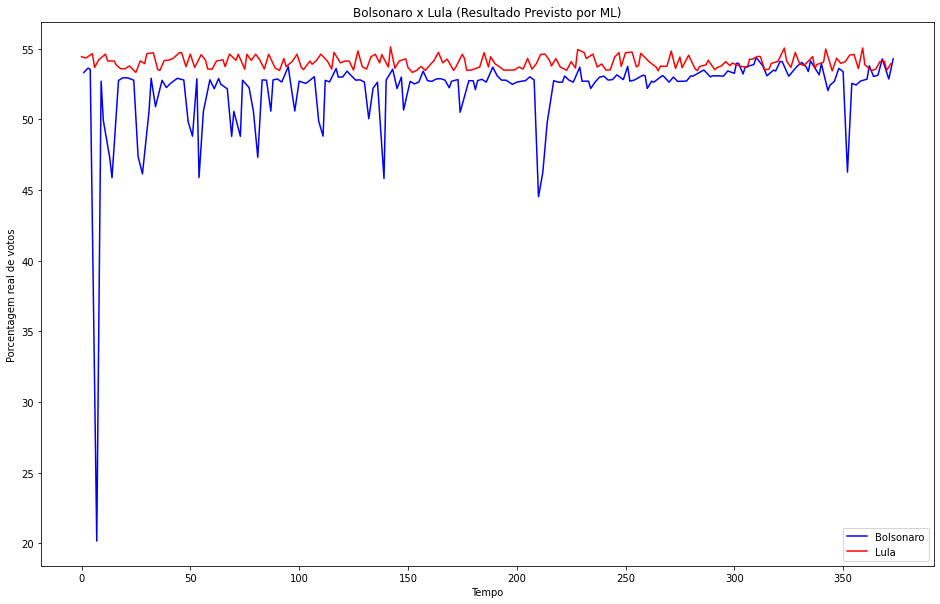

In [47]:
# Resultados Previstos para a eleição! (Time series)

plt.figure(figsize=(16,10))
ax = sns.lineplot(y=dados_final['resultado_real'],x=range(dados_final.shape[0]),hue=dados_final['id_candidato_poder360'],palette=['blue', 'red'])
plt.legend(['Bolsonaro','Lula'])
plt.title('Bolsonaro x Lula (Resultado Previsto por ML)')
ax.set_ylabel('Porcentagem real de votos')
ax.set_xlabel('Tempo')
plt.show()

In [48]:
# Prever resultado final com a média das 5 últimas pesquisas

bolsonaro = dados_final[dados_final['id_candidato_poder360']==706]['resultado_real'].reset_index(drop=True)
lula = dados_final[dados_final['id_candidato_poder360']==973]['resultado_real'].reset_index(drop=True)

print('Resultado Lula:',lula.tail().mean(),'%','+/-',lula.tail().std(),'%')
print('Resultado Bolsonaro:',bolsonaro.tail().mean(),'%','+/-',bolsonaro.tail().std(),'%')

Resultado Lula: 53.83494069659363 % +/- 0.3049687889319998 %
Resultado Bolsonaro: 53.51526298323738 % +/- 0.704358172831257 %


Não filtrei bonitinho, então ele dá um resultado que somando dá mais que 100%, mas mostra que eles tão super próximos!

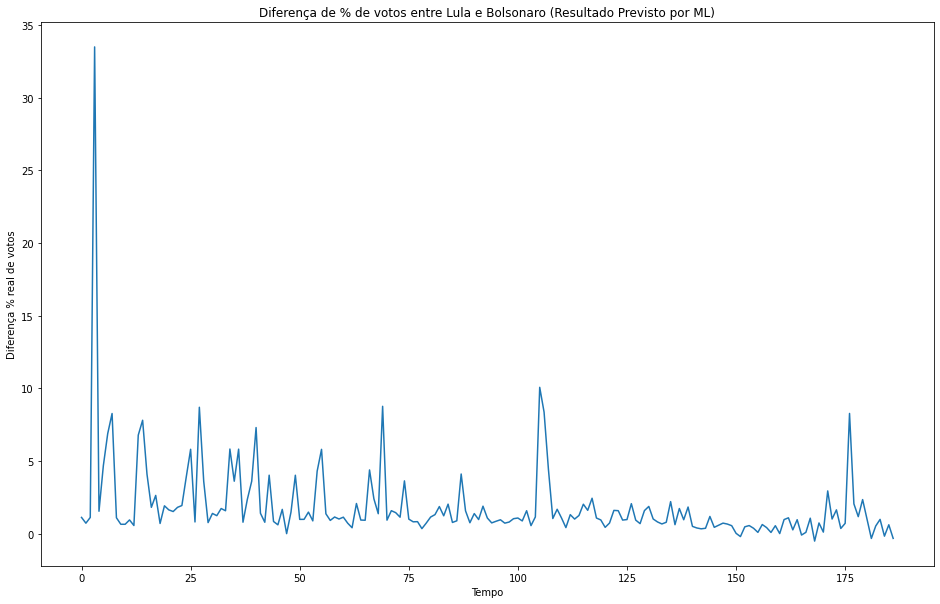

In [49]:
# Diferença de % de votos entre lula e bolsonaro (Time Series)

diferenca_pct = lula-bolsonaro

plt.figure(figsize=(16,10))
ax = sns.lineplot(y=diferenca_pct,x=range(lula.shape[0]))
plt.title('Diferença de % de votos entre Lula e Bolsonaro (Resultado Previsto por ML)')
ax.set_ylabel('Diferença % real de votos')
ax.set_xlabel('Tempo')
plt.show()

In [50]:
# Prever a diferença de % de votos final com as 5 últimas pesquisas

print('Diferença entre bolsonaro e lula:',diferenca_pct.tail().mean(),'%','+/-',diferenca_pct.tail().std(),'%')

Diferença entre bolsonaro e lula: 0.31967771335623923 % +/- 0.5532342843131413 %
